In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn
from copy import deepcopy
import random
VERBOSE = True

In [3]:
out_path = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/'
data_path = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/RAW_DATA'
pd.options.display.max_rows = 100


## Efrat's Readme

Paper: Franzosa, E. A., Sirota-Madi, A., Avila-Pacheco, J., Fornelos, N., Haiser, H. J., Reinker, S., ... & Sauk, J. S. (2019). Gut microbiome structure and metabolic activity in inflammatory bowel disease. Nature microbiology, 4(2), 293.‏
Link: https://www.nature.com/articles/s41564-018-0306-4?WT.feed_name=subjects_virology  

#======================================================================

Samples info: 220, human gut (IBD + Control)

Excel tables taken from study supplementary.

Species abundance xlsx file also includes the following metadata:
	- Age
	- Diagnosis
	- Fecal.Calprotectin
...& drugs intake data:
	- Antibiotic
	- Immunosuppressant
	- Mesalamine
	- Steroids

Raw data (sequences + raw untargeted metabolomics) available with accession numbers:
- Metabolomics Workbench: PR000677
- SRA with BioProject PRJNA400072

For downloading all FASTQ files (0.6 TB), you can also use the bash script: sra_bash_script_for_fastq_download.sh 
(generated by SRA interactive explorer)
SRA-related metadata on each sample can be found in sra_run_table.txt file (also provides the mapping between subject ID's in xlsx files & SRA sample ID's).



# Read the data


The original sequences pre-processed can be found at : https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001204.v1.p1 (should be found but currently arent there)

In [41]:
# Overall this dataset should containt 69 bacterial genera detected in at least 20% of the samples
stgn_raw = pd.read_excel(f'{data_path}/41564_2018_306_MOESM6_ESM.xlsx', engine='openpyxl', header=1)
stgn_raw.shape
N_sxs = stgn_raw.shape[0]-8


In [42]:
# Create a subset of the 16s data that only contains counts, genus and sample ids
stgn_raw_data = stgn_raw.iloc[8:,]
# sxs_raw_data = sxs_raw_data.rename({'# Feature / Sample':'Bacterical genus'}, axis = 1)
stgn_raw_data.set_index('# Feature / Sample', inplace=True)



(201, 220)

In [69]:
print(f'Shape of shotgun species data: {stgn_raw_data.shape}')
stgn_raw_data.head(5)

Shape of shotgun species data: (201, 220)


,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,PRISM|7445,...,Validation|UMCGIBD00588,Validation|UMCGIBD00106,Validation|UMCGIBD00393,Validation|UMCGIBD00458,Validation|UMCGIBD00254,Validation|UMCGIBD00593,Validation|UMCGIBD00233,Validation|UMCGIBD00238,Validation|UMCGIBD00027,Validation|UMCGIBD00064
# Feature / Sample,,,,,,,,,,,,,,,,,,,,,
Methanobrevibacter_smithii,0,0.000019,0,0,0,0,0,0,0,0,...,0.083278,0,0,0,0,0.024554,0,0,0,0
Methanosphaera_stadtmanae,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rothia_mucilaginosa,0,0.000009,0,0,0,0,0.000521,0.000058,0.000104,0,...,0,0,0,0,0,0,0,0,0,0
Propionibacterium_freudenreichii,0,0,0.001754,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bifidobacterium_adolescentis,0.000092,0.000015,0.040328,0.000056,0.000026,0.000064,0.000012,0.000025,0.000015,0.000106,...,0.031199,0,0.000109,0.11614,0,0.288639,0.134661,0.062124,0,0.000012


<AxesSubplot:ylabel='Frequency'>

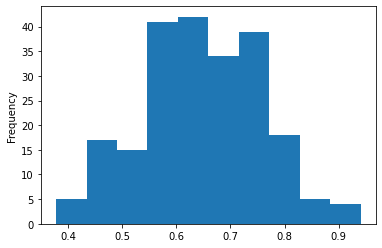

In [43]:
# Describe the sparsity of the 16s data, for each smaple plot the percent of zeros in it.

def count_zeros(row: pd.Series): return sum(row == 0)
def percent_zeros(row: pd.Series): return sum(row == 0)/len(row)

def describe_sparsity(df):
    temp = df.fillna(0)
    res = temp.agg([count_zeros, percent_zeros])
    return res

zeros = describe_sparsity(sxs_raw_data).T
zeros.percent_zeros.plot(kind='hist')






**Most samples have 55-75% zeros.**

### Read Metabolomic data

### From the article's methods - Post-processing of metabolomics data

We used Expressionist version 9.0 (Genedata; Refiner module for MS) to process raw LC–MS data for chemical noise removal, to detect chromatographic peaks and isotope clusters, align retention times between samples and assign putative metabolite identities via database look up. Detailed parameter settings are provided as Supplementary Dataset 8. Across samples, the combination of the four LC–MS methods generated 8,869 clustered features, characterized by chromatographic retention time and exact mass to < 5 ppm accuracy. Note that these clustered features, referred to as metabolites or metabolite features elsewhere in the text, are presumed to represent a single molecular species. Broader clusters of metabolite features, presumed to represent families of related molecular species, were also constructed using the results of linear regression analysis and are described later. Within each sample and LC–MS method, feature intensities were sum-normalized to ppm units.

A subset of 466 metabolites were identified more precisely using reference data generated from an in-house compound library; 3,829 metabolite features were linked to putative identifiers based on accurate m/z matching against the HMDB. Analyses of putatively matched features in the text focus on their molecular classes, rather than their identities. More specifically, we assigned HMDB subclasses to these features as a form of broad chemical classification. Subclasses assigned to >100 features (for example, ‘fatty acyls’) were further broken  down according HMDB’s ‘direct parent’ annotations.  

s


In [44]:
# Read metabolites raw data and data that has been curated by Efrat
metab_raw = pd.read_excel(f'{data_path}/41564_2018_306_MOESM4_ESM.xlsx', engine='openpyxl', header=1)

N_metab = metab_raw.shape[0]-8
metab_raw.head(50)

,# Feature / Sample,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,...,Validation|UMCGIBD00588,Validation|UMCGIBD00106,Validation|UMCGIBD00393,Validation|UMCGIBD00458,Validation|UMCGIBD00254,Validation|UMCGIBD00593,Validation|UMCGIBD00233,Validation|UMCGIBD00238,Validation|UMCGIBD00027,Validation|UMCGIBD00064
0,Age,38,50,41,51,68,67,59,52,58,...,68,42,65,44,71,21,32,38,51,43
1,Diagnosis,CD,CD,CD,CD,CD,CD,CD,CD,CD,...,UC,CD,UC,CD,CD,UC,CD,CD,CD,CD
2,Fecal.Calprotectin,207.484429,NaN,218.334517,NaN,20.167951,2.586247,NaN,NaN,79.331012,...,440,40,130,165,195,40,45,305,44,NaN
3,antibiotic,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,immunosuppressant,Yes,No,Yes,No,No,Yes,No,Yes,No,...,No,No,No,No,No,No,Yes,Yes,Yes,No
5,mesalamine,No,Yes,No,Yes,No,No,Yes,No,Yes,...,Yes,No,Yes,No,No,Yes,No,No,No,No
6,steroids,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes
7,C18-neg_Cluster_0001,0,1635.54,0,203.783,0,384.437,0,0,451.549,...,3313.47,0,2632.74,0,0,2944.38,0,0,0,0
8,C18-neg_Cluster_0002,6391.01,27.4461,8265.9,14.2666,332.206,322.586,0,142.036,365.84,...,291.309,169.415,85.3162,145.734,168.967,293.233,1017.67,411.05,453.672,124.752
9,C18-neg_Cluster_0003,288.808,59.2412,7708.63,57.3647,42.5518,363.142,74.088,326.186,1239.83,...,234.969,99.1709,89.5537,689.002,4714.22,86.8866,71.9505,2631.76,24.7567,544.112


In [45]:
# Create a subset of the 16s data that only contains counts, genus and sample ids
metab_raw_data = metab_raw.iloc[8:,]
# sxs_raw_data = sxs_raw_data.rename({'# Feature / Sample':'Bacterical genus'}, axis = 1)
metab_raw_data.set_index('# Feature / Sample', inplace=True)

metab_raw_data.head(30)
metab_raw_data.shape

(8847, 220)

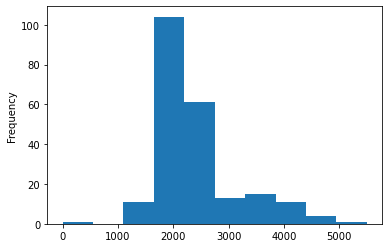

Number of metabolites: 8855
Median number of zeros per sample: is 24.2%.
(median number of zeros per sample: 2141.0)


In [46]:
describe_sparsity(metab_raw).T.count_zeros.plot(kind='hist')
plt.show()
print(f"Number of metabolites: {metab_raw.shape[0]}")
median_zero_number = describe_sparsity(metab_raw).T.count_zeros.median(axis =0)
print(f"Median number of zeros per sample: is {round((median_zero_number/N_metab) * 100, 2)}%.\n"
      f"(median number of zeros per sample: {median_zero_number})")


In [56]:
# Create a set of the common column names, representing the common samples that have both metabolomics and 16s
sample_ids = stgn_raw_data.columns.intersection(metab_raw.columns)
print(f'Mutual set of samples is of size: {len(sample_ids)}')
# Extract 8 first rows of metadata
metadata = sxs_raw.iloc[0:8,:]
metadata


Mutual set of samples is of size: 220


,# Feature / Sample,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,...,Validation|UMCG6966873,Validation|UMCG7115152,Validation|UMCG7198526,Validation|UMCG7563651,Validation|UMCG8089650,Validation|UMCG8255148,Validation|UMCG8438880,Validation|UMCG9119812,Validation|UMCG9189151,Validation|UMCG9830707
0,SRA_metagenome_name,G36386,G48796,G48780,G36390,G36356,G36387,G48804,G48815,G36378,...,G85257,G85419,G85340,G85418,G85122,G85136,G85405,G85166,G85210,G85342
1,Age,38,50,41,51,68,67,59,52,58,...,68,42,65,44,71,21,32,38,51,43
2,Diagnosis,CD,CD,CD,CD,CD,CD,CD,CD,CD,...,UC,CD,UC,CD,CD,UC,CD,CD,CD,CD
3,Fecal.Calprotectin,207.484429,NaN,218.334517,NaN,20.167951,2.586247,NaN,NaN,79.331012,...,440,40,130,165,195,40,45,305,44,NaN
4,antibiotic,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No
5,immunosuppressant,Yes,No,Yes,No,No,Yes,No,Yes,No,...,No,No,No,No,No,No,Yes,Yes,Yes,No
6,mesalamine,No,Yes,No,Yes,No,No,Yes,No,Yes,...,Yes,No,Yes,No,No,Yes,No,No,No,No
7,steroids,No,No,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes


### Create dataframes for working only with samples that have both 16s and metabolomics

In [59]:
# Create dataframes with common sample rows for downstream analysis

mbdf = metab_raw_data[sample_ids]
stgndf = stgn_raw_data[sample_ids]

N_stgn = stgndf.shape[0] # Num of species
N_metab = mbdf.shape[0] # Num of metabolites
N_samples = len(sample_ids) # Num of samples


## Separtion of DeepLife and PRISM cohorts
Since the data actually comes from three different cohorts we split it accordingly and analyze each split seperately.  
Cohorts are: **PRISM** (discovery cohort in original paper) and **LifeLines**, **NLIBD** (Validation cohorts).

In [157]:
mbdf_NLIBD, mbdf_LL, mbdf_PRISM  = mbdf.filter(regex='UMCGIBD*', axis = 1), mbdf.filter(regex='LLDeep*', axis = 1), mbdf.filter(regex='PRISM*', axis = 1)
stgndf_NLIBD, stgndf_LL, stgndf_PRISM  = stgndf.filter(regex='UMCGIBD*', axis = 1), stgndf.filter(regex='LLDeep*', axis = 1), stgndf.filter(regex='PRISM*', axis = 1)


### Describe sparsity of each shotgun cohort sperately

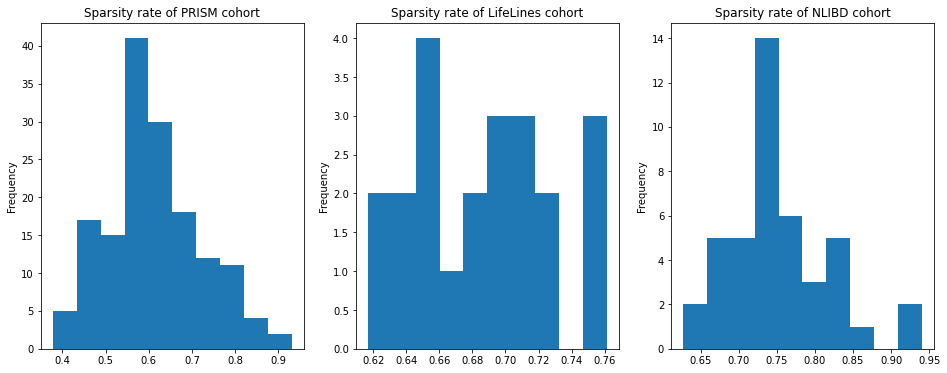

In [126]:



# equivalent but more general
# fig, ax = plt.subplots()
# ax.plot(x, y)
# ax.set_title('Simple plot')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))

zeros = describe_sparsity(stgndf_PRISM).T
zeros.percent_zeros.plot(kind='hist', ax=ax1)
ax1.set_title('Sparsity rate of PRISM cohort')

zeros = describe_sparsity(stgndf_LL).T
zeros.percent_zeros.plot(kind='hist', ax=ax2)
ax2.set_title('Sparsity rate of LifeLines cohort')

zeros = describe_sparsity(stgndf_NLIBD).T
zeros.percent_zeros.plot(kind='hist', ax=ax3)
ax3.set_title('Sparsity rate of NLIBD cohort')


plt.show()


## Preprocess the data according to the paper
**From the subsection statistical analysis in the methods section of the paper:**  
* *Each data type was analysed separately in each cohort.*
* *Relative abundance values were log-transformed to variance-stabilize the data.*
* *Zero values were additively smoothed by half the smallest non-zero measurement on a per-sample basis.*
* *For both cohorts, we modelled the transformed abundance of each feature as a function of IBD phenotype (modelled as a categorical variable with ‘non-IBD control’ as the reference state), with age as a continuous covariate in both cohorts, and four medications (antibiotics, immunosuppressants, mesalamine and steroids) as binary covariates in the PRISM cohort.*


In [158]:
stgndf_PRISM

,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,PRISM|7445,...,PRISM|8982,PRISM|8998,PRISM|9010,PRISM|9018,PRISM|9030,PRISM|9033,PRISM|9074,PRISM|9079,PRISM|9126,PRISM|9148
# Feature / Sample,,,,,,,,,,,,,,,,,,,,,
Methanobrevibacter_smithii,0,0.000019,0,0,0,0,0,0,0,0,...,0.026359,0,0,0,0,0.004906,0,0,0,0
Methanosphaera_stadtmanae,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.004606,0,0,0,0
Rothia_mucilaginosa,0,0.000009,0,0,0,0,0.000521,0.000058,0.000104,0,...,0,0,0,0,0,0,0,0,0.000229,0
Propionibacterium_freudenreichii,0,0,0.001754,0,0,0,0,0,0,0,...,0,0,0,0,0.000287,0,0,0,0,0
Bifidobacterium_adolescentis,0.000092,0.000015,0.040328,0.000056,0.000026,0.000064,0.000012,0.000025,0.000015,0.000106,...,0.000003,0,0.000022,0.000028,0.000013,0.565125,0.000071,0.000014,0.000003,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Collinsella_stercoris,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides_clarus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bacteroides_plebeius,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# temp = stgndf_PRISM.replace(0, np.nan)

min_abundance_per_sample = stgndf_PRISM.apply(lambda row: row.replace(0, np.nan).dropna().min())

NameError: name 'sample' is not defined

In [183]:
stgndf_PRISM = stgndf_PRISM.astype(float)
stgndf_PRISM_no_zeros = stgndf_PRISM.apply(lambda sample: sample.replace(0, min_abundance_per_sample[sample.name]/2))
stgndf_PRISM_processed = stgndf_PRISM_no_zeros.apply(lambda row: -1*np.log10(row))
# stgndf_PRISM.apply(lambda sample: sample.name)
# stgndf_PRISM_transformed = stgndf_PRISM.apply(lambda row: -np.log10(row))
 

In [184]:
stgndf_PRISM_processed

,PRISM|7122,PRISM|7147,PRISM|7150,PRISM|7153,PRISM|7184,PRISM|7238,PRISM|7406,PRISM|7408,PRISM|7421,PRISM|7445,...,PRISM|8982,PRISM|8998,PRISM|9010,PRISM|9018,PRISM|9030,PRISM|9033,PRISM|9074,PRISM|9079,PRISM|9126,PRISM|9148
# Feature / Sample,,,,,,,,,,,,,,,,,,,,,
Methanobrevibacter_smithii,5.638272,4.716699,5.809668,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,1.579078,5.576754,5.501689,4.861697,5.474955,2.309299,5.091515,5.869666,5.809668,5.530178
Methanosphaera_stadtmanae,5.638272,6.045757,5.809668,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,5.782516,5.576754,5.501689,4.861697,5.474955,2.336638,5.091515,5.869666,5.809668,5.530178
Rothia_mucilaginosa,5.638272,5.026872,5.809668,5.351640,6.0000,5.721246,3.283162,4.233587,3.984640,5.455932,...,5.782516,5.576754,5.501689,4.861697,5.474955,5.886057,5.091515,5.869666,3.640544,5.530178
Propionibacterium_freudenreichii,5.638272,6.045757,2.755995,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,5.782516,5.576754,5.501689,4.861697,3.542724,5.886057,5.091515,5.869666,5.809668,5.530178
Bifidobacterium_adolescentis,4.036684,4.832683,1.394394,4.248721,4.5867,4.192465,4.920819,4.596879,4.818156,3.974285,...,5.455932,5.576754,4.651695,4.560667,4.896196,0.247855,4.146910,4.866461,5.508638,4.071604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Collinsella_stercoris,5.638272,6.045757,5.809668,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,5.782516,5.576754,5.501689,4.861697,5.474955,5.886057,5.091515,5.869666,5.809668,5.530178
Bacteroides_clarus,5.638272,6.045757,5.809668,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,5.782516,5.576754,5.501689,4.861697,5.474955,5.886057,5.091515,5.869666,5.809668,5.530178
Bacteroides_plebeius,5.638272,6.045757,5.809668,5.351640,6.0000,5.721246,6.455932,6.000000,5.356547,5.455932,...,5.782516,5.576754,5.501689,4.861697,5.474955,5.886057,5.091515,5.869666,5.809668,5.530178


## Extraction of important correlations between metabolites and bacteria
1. Find correlations in general
2. Filter weak correlations (e.g |corr| < .3) 
3. For each metabolite or specie create a dictionary with the specie or metabolies (opposite accordigly) that have strong correlation with it

In [185]:
# 1. Find correlations between 16s and metabolites (correlations between rows based on shared columns)
# Since we'd like to use the non-zero center of the mass values to infer about the quantity of the lower values,
# we drop the zeros and then take the upper 80% of the data for each OTU. 
# Based on these upper 80% of each OTU we search for correlations in the metabolite data.

In [186]:
# 2. we define a strong correlation as >.3 or <-.3 in the case of negative correlation
CORR_THRESHOLD = 0.3


In [187]:
def is_var_specie(idx):
    return True if idx <= N_sxs else False

def extract_high_corrs(row, idx):
    coefs = {}
    if is_var_specie(idx):
        coefs = row[N_sxs+1:].dropna().to_dict()
        
    else:
        coefs = row[0:N_sxs].dropna().to_dict()
    
    return coefs

In [188]:
# Constants 

VERBOSE = False
EPSILON = 0.01
CORR_THRESHOLD = 0.3


For each specie (column in stgndf_PRISM), we:  
1. construct a vector of non-zero samples.
2. Take the upper 80% percent of the vector (meaning the top 80% relative abundance counts of non zero samples)
3. Find the correlations between this samples and the same samples in the Metabolomic data (mbdf)
4. Filter Strong correlations only - Above <CORR_THRESHOLD> and store them in strong_corr_dict  
    a. If there are no such correlation we skip the rest
5. We then back plot the OTU and the Metabolites using one color for samples that were used in the process of finding the correlations and other color for samples that belong to the lower 20% or either are 0s.


Methanobrevibacter_smithii
<bound method NDFrame._add_numeric_operations.<locals>.min of PRISM|7122    5.638272
PRISM|7147    4.716699
PRISM|7150    5.809668
PRISM|7153    5.351640
PRISM|7184    6.000000
                ...   
PRISM|9033    2.309299
PRISM|9074    5.091515
PRISM|9079    5.869666
PRISM|9126    5.809668
PRISM|9148    5.530178
Name: Methanobrevibacter_smithii, Length: 155, dtype: float64>
PRISM|7122    5.638272
PRISM|7147    4.716699
PRISM|7150    5.809668
PRISM|7153    5.351640
PRISM|7184    6.000000
                ...   
PRISM|9033    2.309299
PRISM|9074    5.091515
PRISM|9079    5.869666
PRISM|9126    5.809668
PRISM|9148    5.530178
Name: Methanobrevibacter_smithii, Length: 155, dtype: float64
For otu: Methanobrevibacter_smithii, initial length is 155.
Number of zeros is: 0 Number of values above 20 percentile: 30

Methanosphaera_stadtmanae
<bound method NDFrame._add_numeric_operations.<locals>.min of PRISM|7122    5.638272
PRISM|7147    6.045757
PRISM|7150    5.809668

/Users/d_private/anaconda3/envs/microbiome1/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/d_private/anaconda3/envs/microbiome1/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


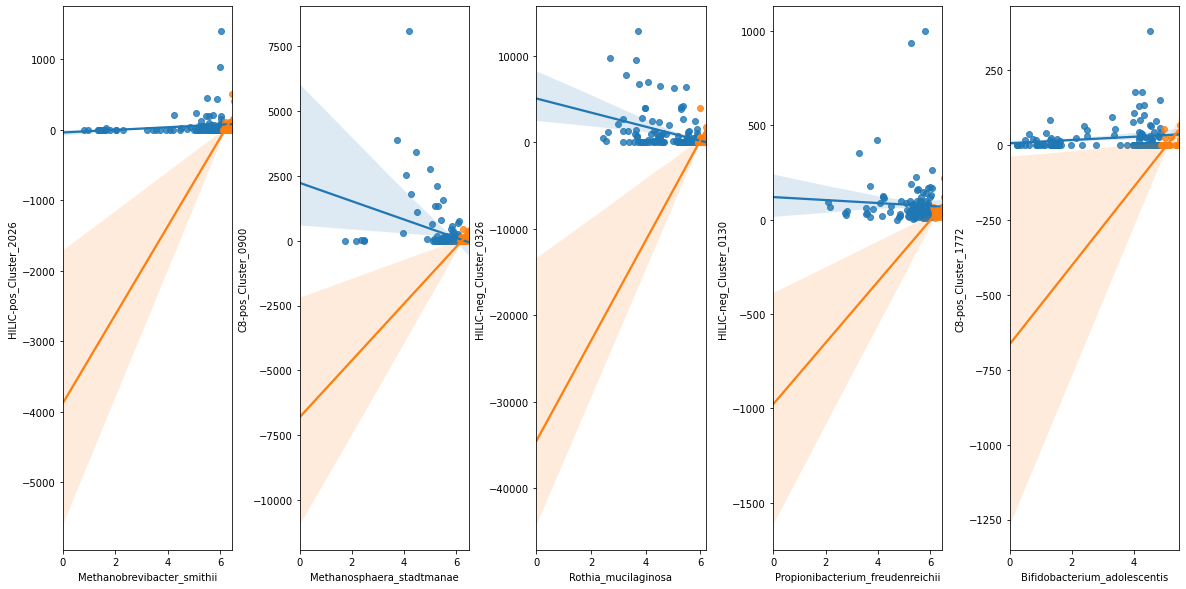

In [206]:

fig = plt.figure(figsize=(20,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = True



for i, (otu, row) in enumerate(list(stgndf_PRISM_processed.iterrows())[:5], 1):
    
    print(otu)
    print(row)
    '''
    no_zeros = row.where(row > row.min())
    print(row.min)
    print(no_zeros)
    q_20 = no_zeros.quantile(.8)
    q_01 = no_zeros.quantile(.01)

    ra_over_q20 = no_zeros[no_zeros.map(lambda x: x > q_20)]
    
    if VERBOSE:
        print(f"For otu: {otu}, initial length is {len(row)}.\n"
              f"Number of zeros is: {row.apply(lambda val: val==0).sum()} "
              f"Number of values above 20 percentile: {len(ra_over_q20)}\n")
    
    # Step 3 - Find all correlations
    corr = np.corrcoef(ra_over_q20.to_numpy().astype(float), mbdf_PRISM[ra_over_q20.index].to_numpy().astype(float)) 
    corr = pd.DataFrame(corr, 
                        columns = [otu] + list(mbdf_PRISM.index),
                        index = [otu] + list(mbdf_PRISM.index))
    
    # Step 4 - Filter out weak correlations 
    strong_corr = corr.loc[otu,:]
    strong_corr = strong_corr.where((strong_corr < .99) & (abs(strong_corr) > CORR_THRESHOLD)).dropna()
    strong_corr_dict[otu] = strong_corr
    strongest_corr_dict[otu] = strong_corr.where(abs(strong_corr) == abs(strong_corr).max()).dropna()
    
    # If no strong correlation was found, plot a infromative texst instead of a graph and skip the rest.
    if(len(strongest_corr_dict[otu]) == 0): 
        continue
        ax = fig.add_subplot(9, 8, i)
        ax.text(0.2, 0.4, f"{otu}:\n No strong correlations found", fontsize=12)

        
        
    # Prepare a unified dataframe with a column of the OTU relatvie abundances, Metabolites                 
    is_over_q20 = row > q_20
    df_full = pd.DataFrame(data = [row.replace(0, q_01/((row==0).sum()+1)), 
                                   mbdf_PRISM.loc[strongest_corr_dict[otu].index[0],:]])
    df_full = df_full.T    
        
            
    # Add Indicator columns for weather a samples is used or not (i.e it belongs to upper 80% or not.)
    df_full['is_over_q20'] = is_over_q20
    df_full['color']= np.where(is_over_q20==True , "#9b59b6", "#3498db")
    
    # Possible to back transform the data     
    # df_full[otu] = df_full[otu].apply(lambda x: -1*np.log(np.sin(x**2)))
    
    # Step 5 - Plotting

    ax = fig.add_subplot(1, 5, i)
    ax.set_xlim([0, row.quantile(.95)])
#     i+=1

#     sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full,
#                      scatter_kws={'facecolors': df_full.color}, fit_reg=True, logx=False,
#                 ax=ax)
    
    l1 = sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full.loc[~df_full['is_over_q20']],
#                      scatter_kws={'facecolors': df_full.color},
            fit_reg=True, logx=False, ax=ax, truncate=False, label = 'Zeros and <q20')
    
    l2 = sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full.loc[df_full['is_over_q20']],
                fit_reg=True, logx=False, ax=ax,  truncate=False, label = '>q20, Used'
    #                          scatter_kws={'facecolors': df_full.loc[df_full['is_over_q20']].color}
        )
    
    
    pearson_r = round(strongest_corr_dict[otu][0], 2)
    r_squared = round(pearson_r**2, 2)
#     txt = f"{otu.split(';')[1]} vs. {strongest_corr_dict[otu].index[0]},\n r: {pearson_r}, r^2: {r_squared}"    
    
#     ax.title.set_text(txt)
#     plt.show()


plt.savefig('corrs.png')
plt.show()


    




### Build an RF predictor and plot 

1. Tradtional train-test split 0.8:0.2

In [34]:
from sklearn.model_selection import train_test_split

sxs_train, sxs_test = train_test_split(sxsdf.T, train_size = 0.8, test_size = 0.2, shuffle=True)
train_ids = sxs_train.T.columns.intersection(sample_ids)
test_ids = sxs_test.T.columns.intersection(sample_ids)


sxs_train, sxs_test = sxs_train.T, sxs_test.T
mb_train, mb_test = mbdf.loc[:,train_ids], mbdf.loc[:,test_ids]

After the train-test split we end up with the following dimensions:  
* Train - 192 samples  
* Test - 48 samples  


Now building rf regressor for otu: Actinobacteria;Actinomyces
Finished, test RMSE: 0.0151
Now building rf regressor for otu: Actinobacteria;Adlercreutzia
Finished, test RMSE: 0.01464
Now building rf regressor for otu: Actinobacteria;Bifidobacterium
Finished, test RMSE: 0.01842
Now building rf regressor for otu: Actinobacteria;Collinsella
Finished, test RMSE: 0.04009
Now building rf regressor for otu: Actinobacteria;Coriobacterium
Finished, test RMSE: 0.00702
Now building rf regressor for otu: Actinobacteria;Eggerthella
Finished, test RMSE: 0.01065
Now building rf regressor for otu: Actinobacteria;Slackia
Finished, test RMSE: 0.01598
Now building rf regressor for otu: Bacteroidetes;Bacteroides
Finished, test RMSE: 0.18061
Now building rf regressor for otu: Bacteroidetes;Butyricimonas
Finished, test RMSE: 0.04158
Now building rf regressor for otu: Bacteroidetes;Odoribacter
Finished, test RMSE: 0.07156
Now building rf regressor for otu: Bacteroidetes;PW3
Finished, test RMSE: 0.01187
Now b

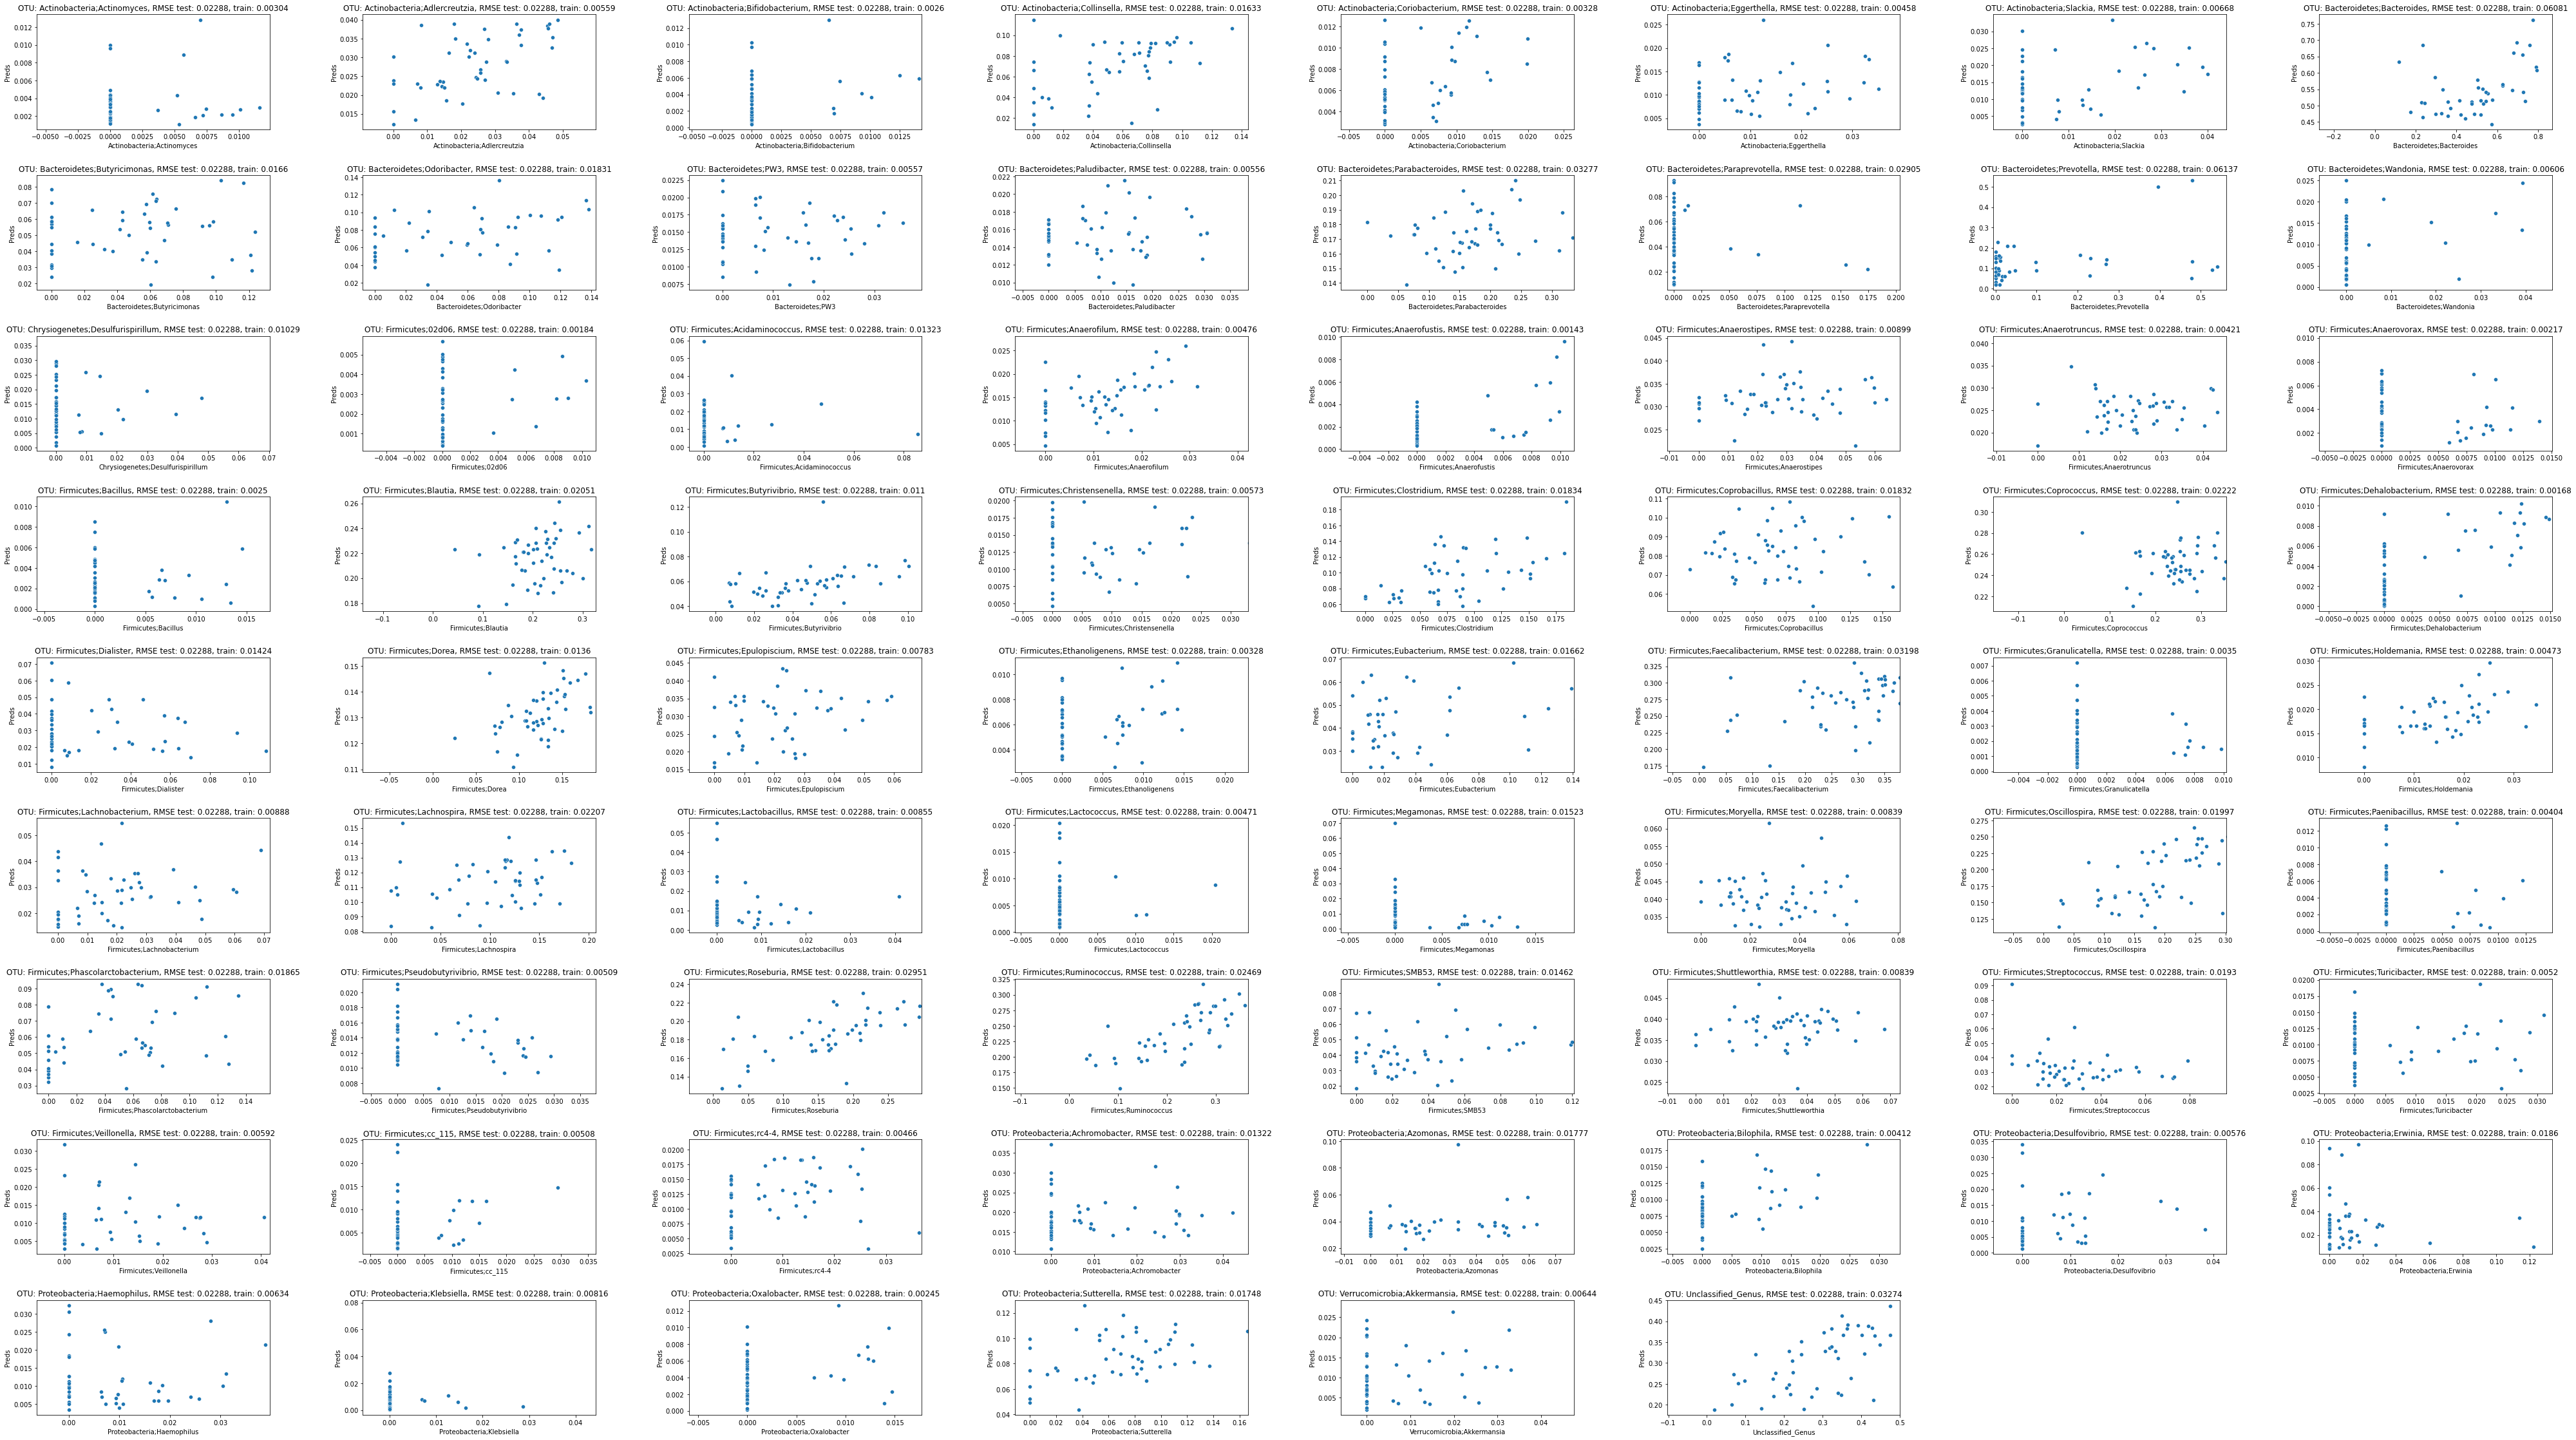

In [84]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error as RMSE

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = False

mod = RF(n_jobs = 8)
fig = plt.figure(figsize=(70,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (otu, row) in enumerate(list(sxs_train.iterrows())[:-1], 1):
    
    if VERBOSE:
        print(f"Now building rf regressor for otu: {otu}")
    
    
    _y = row
    _X = mb_train.T
    
    _y_test_observed = sxs_test.loc[otu,:]
    _X_test = mb_test.T
    
    
        
    mod.fit(_X, _y)
        
    preds = pd.Series(data = mod.predict(_X_test), index = _y_test_observed.index, name=f'Preds')
    train_preds = pd.Series(data = mod.predict(_X), index = _y.index, name=f'Preds')
    
    
    compare_df = pd.DataFrame(data = [_y_test_observed, preds], dtype=np.float64).T
    compare_train_df = pd.DataFrame(data = [_y, train_preds], dtype=np.float64).T
    compare_train_df['is_train_data'] = True
    compare_df['is_train_data'] = False
    
    preds_vs_obs_df = pd.concat([compare_df, compare_train_df])
#     compare_df = compare_df.apply(lambda col: col.astype(np.float64), axis = 0)

    
    
    ax = fig.add_subplot(9, 8, i)
    no_zeros = row.replace(0, np.nan).dropna() # Just for calculating some xlim that is lower than 0 for visu
    ax.set_xlim([-no_zeros.quantile(.05), row.quantile(.95)])

    s1 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds, 
                         data=preds_vs_obs_df.loc[~preds_vs_obs_df['is_train_data']], ax=ax)
#                      fit_reg=True, logx=False, ax=ax, truncate=False, label = 'Zeros and <q20')
    
#     s2 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds,
#                          data=preds_vs_obs_df.loc[preds_vs_obs_df['is_train_data']], ax=ax)

#     l2 = sns.regplot(x=otu, y=compare_df.Preds, data=compare_df, ax=ax,
#                 fit_reg=True, logx=False,   truncate=False
#                          scatter_kws={'facecolors': df_full.loc[df_full['is_over_q20']].color})
    
    

    
    
    test_rmse = round(RMSE(_y_test_observed, preds, squared=False), 5)
    train_rmse = round(RMSE(_y, train_preds, squared=False), 5)
    ax.set_title(f'OTU: {otu}, RMSE test: {test_rmse}, train: {train_rmse}')

    if VERBOSE:
        print(f"Finished, test RMSE: {test_rmse}")
 


plt.savefig('RF_predictor_no_train.png')
plt.show()


    





2. Train-Test split based on the partitioning to zeros and non zeros.  We train on 80% of the non-zero values

For otu: Actinobacteria;Actinomyces, train size: 65, test size = 175
Number of zeros is: 158
Number of values above 20 percentile: 83
Finished, RMSE test: 0.01253, train: 0.00639

For otu: Actinobacteria;Adlercreutzia, train size: 179, test size = 61
Number of zeros is: 16
Number of values above 20 percentile: 83
Finished, RMSE test: 0.02487, train: 0.00515

For otu: Actinobacteria;Bifidobacterium, train size: 50, test size = 190
Number of zeros is: 177
Number of values above 20 percentile: 83
Finished, RMSE test: 0.01792, train: 0.00629

For otu: Actinobacteria;Collinsella, train size: 158, test size = 82
Number of zeros is: 42
Number of values above 20 percentile: 83
Finished, RMSE test: 0.0788, train: 0.01415

For otu: Actinobacteria;Coriobacterium, train size: 84, test size = 156
Number of zeros is: 135
Number of values above 20 percentile: 83
Finished, RMSE test: 0.01498, train: 0.00327

For otu: Actinobacteria;Eggerthella, train size: 126, test size = 114
Number of zeros is: 82
N

Finished, RMSE test: 0.10837, train: 0.01722

For otu: Firmicutes;Paenibacillus, train size: 41, test size = 199
Number of zeros is: 189
Number of values above 20 percentile: 83
Finished, RMSE test: 0.01787, train: 0.00611

For otu: Firmicutes;Phascolarctobacterium, train size: 137, test size = 103
Number of zeros is: 68
Number of values above 20 percentile: 83
Finished, RMSE test: 0.10034, train: 0.0138

For otu: Firmicutes;Pseudobutyrivibrio, train size: 114, test size = 126
Number of zeros is: 97
Number of values above 20 percentile: 83
Finished, RMSE test: 0.02395, train: 0.00413

For otu: Firmicutes;Roseburia, train size: 192, test size = 48
Number of zeros is: 0
Number of values above 20 percentile: 83
Finished, RMSE test: 0.15505, train: 0.02156

For otu: Firmicutes;Ruminococcus, train size: 192, test size = 48
Number of zeros is: 0
Number of values above 20 percentile: 83
Finished, RMSE test: 0.12718, train: 0.0213

For otu: Firmicutes;SMB53, train size: 156, test size = 84
Num

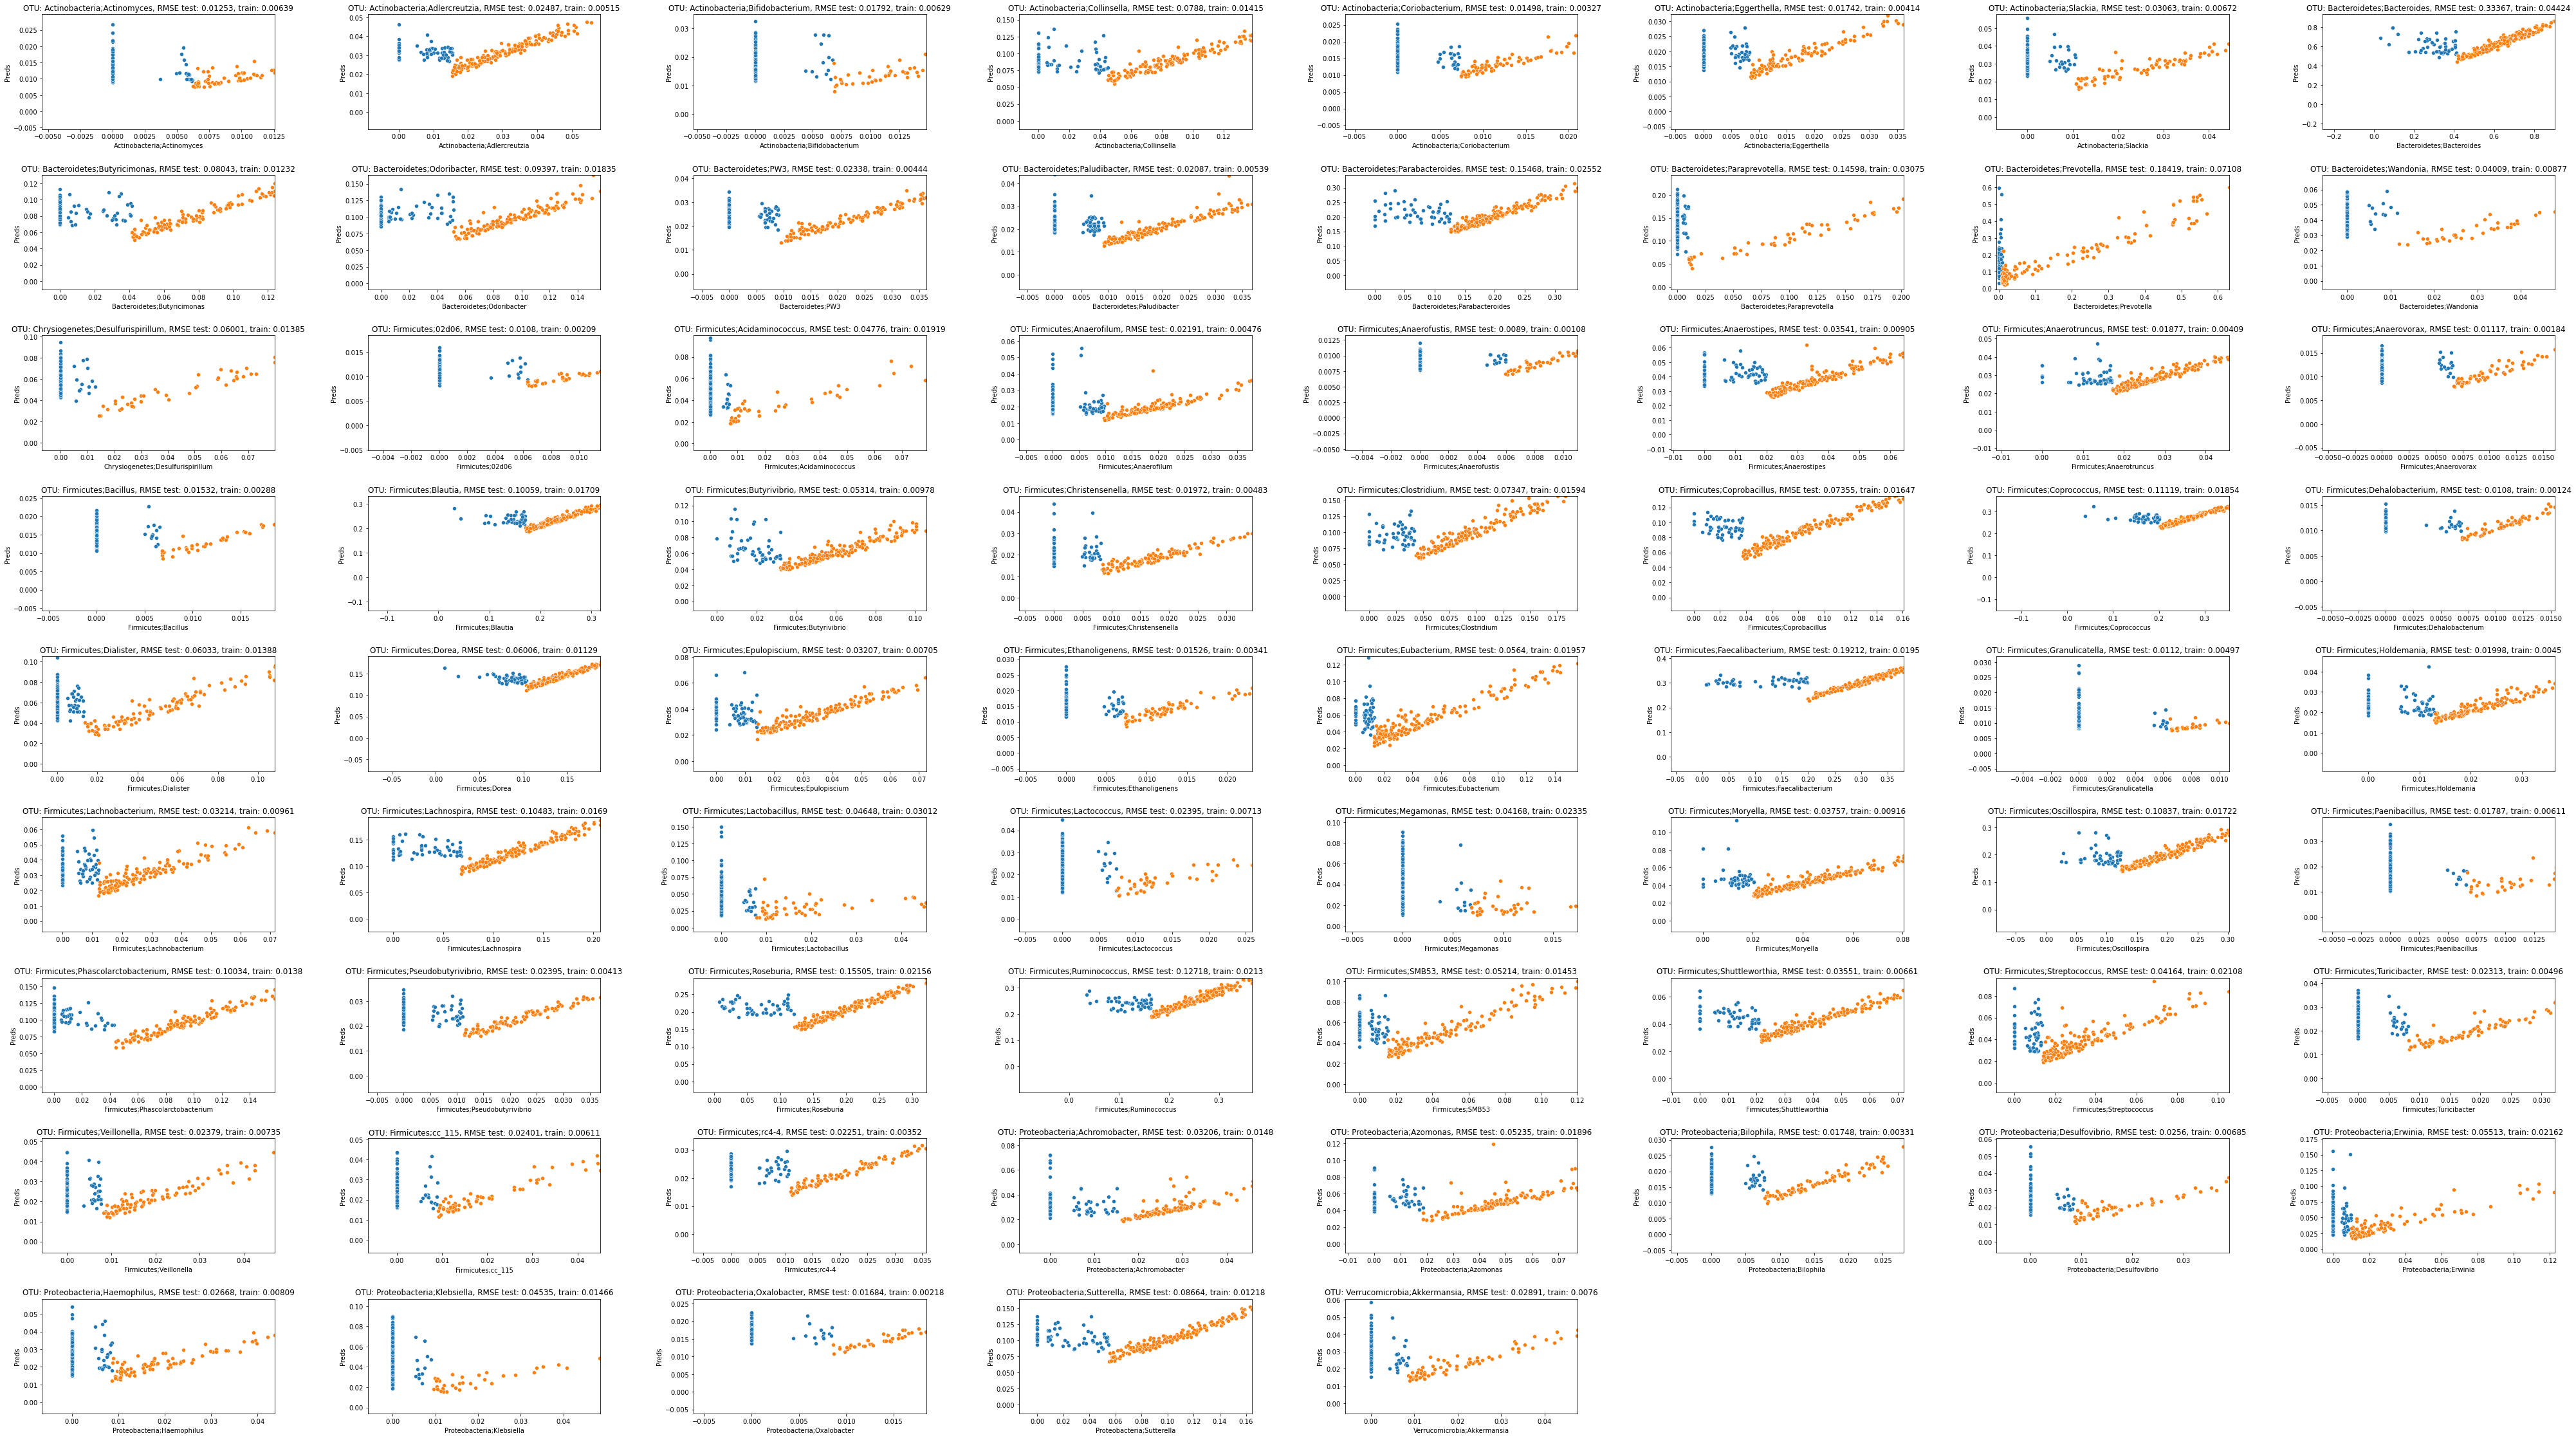

In [152]:

fig = plt.figure(figsize=(70,40))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = True


mod = RF(n_jobs = 8)
for i, (otu, row) in enumerate(list(sxsdf.iterrows())[:-1], 1):
    
    #Step 1 - Split into train & test data where test data inclueds: all zeros and lower 20 percentiles of the non-zeros
    
    no_zeros = row.replace(0, np.nan).dropna()
    q_20 = no_zeros.quantile(.20)
    
    
    # y train is the ra (relative abundance) of the 80 upper percentile of non zero samples
    _y_train = no_zeros[no_zeros.map(lambda x: x >= q_20)]

    # X train is the metabolite features of the dervied samples that were chosen
    _X_train = mbdf[_y_train.index].T
    
    _y_test_observed = row[row.map(lambda x: x < q_20)]
    _X_test = mbdf[_y_test_observed.index].T
    

    if VERBOSE:
        print(f"For otu: {otu}, train size: {_X_train.shape[0]}, test size = {240-_X_train.shape[0]}\n"
              f"Number of zeros is: {row.apply(lambda val: val==0).sum()}\n"
              f"Number of values above 20 percentile: {len(ra_over_q20)}")
        
            
    mod.fit(_X_train, _y_train)
    
    
        
    preds = pd.Series(data = mod.predict(_X_test), index = _y_test_observed.index, name=f'Preds')
    train_preds = pd.Series(data = mod.predict(_X_train), index = _y_train.index, name=f'Preds')
    
    
    compare_df = pd.DataFrame(data = [_y_test_observed, preds], dtype=np.float64).T
    compare_train_df = pd.DataFrame(data = [_y_train, train_preds], dtype=np.float64).T
    compare_train_df['is_train_data'] = True
    compare_df['is_train_data'] = False
    preds_vs_obs_df = pd.concat([compare_df, compare_train_df])    
    
    ax = fig.add_subplot(9, 8, i)
    no_zeros = row.replace(0, np.nan).dropna() # Just for calculating some xlim that is lower than 0 for visu
    ax.set_xlim([-no_zeros.quantile(.05), row.quantile(.95)])
    ax.set_ylim([-no_zeros.quantile(.05), 1.2*preds.quantile(.99)])

    s1 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds, 
                         data=preds_vs_obs_df.loc[~preds_vs_obs_df['is_train_data']], ax=ax)
    
    s2 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds,
                     data=preds_vs_obs_df.loc[preds_vs_obs_df['is_train_data']], ax=ax)
    
    test_rmse = round(RMSE(_y_test_observed, preds, squared=False), 5)
    train_rmse = round(RMSE(_y_train, train_preds, squared=False), 5)
    ax.set_title(f'OTU: {otu}, RMSE test: {test_rmse}, train: {train_rmse}')

    if VERBOSE:
        print(f"Finished, RMSE test: {test_rmse}, train: {train_rmse}\n")


plt.savefig('RF_predict_zeros_based_division.png')
plt.show()


    




In [27]:
df_full.is_over_q20.astype(int)

H001    0
H002    1
H003    1
H004    1
H005    1
       ..
C032    1
C033    1
C034    1
C035    1
C036    1
Name: is_over_q20, Length: 240, dtype: int64

In [188]:
otu

'Bacteroidetes;Odoribacter'

In [189]:
df

,Bacteroidetes;Butyricimonas,MYRISTATE__14_0_
H002,0.049795,-0.407934
H003,0.043040,0.675430
H004,0.067394,-0.882066
H008,0.076761,-0.165579
H010,0.054818,-0.469288
...,...,...
C026,0.045562,-0.543179
C030,0.056796,-0.307682
C034,0.149731,0.410339
C035,0.113341,0.871117


<AxesSubplot:xlabel='Actinobacteria;Collinsella', ylabel='ARGININE'>

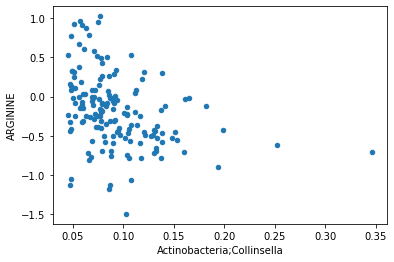

In [140]:
df.plot(kind = 'scatter', x = 'Actinobacteria;Collinsella', y='ARGININE')


In [113]:
strongest_corr_dict

{'Actinobacteria;Actinomyces': ARABONATE_XYLONATE    0.530512
 Name: Actinobacteria;Actinomyces, dtype: float64,
 'Actinobacteria;Adlercreutzia': Series([], Name: Actinobacteria;Adlercreutzia, dtype: float64),
 'Actinobacteria;Bifidobacterium': GAMMA_GLUTAMYLMETHIONINE    0.477095
 Name: Actinobacteria;Bifidobacterium, dtype: float64,
 'Actinobacteria;Collinsella': ARGININE   -0.352417
 Name: Actinobacteria;Collinsella, dtype: float64,
 'Actinobacteria;Coriobacterium': Series([], Name: Actinobacteria;Coriobacterium, dtype: float64)}

In [92]:
strong_corr = corr.loc[otu,:]

X_1_PALMITOYL_GPE__16_0_         -0.300514
X_2__DEOXYCYTIDINE               -0.325983
X_5__2_HYDROXYETHYL__4_METHYLT   -0.303364
X_5_AMINOVALERATE                -0.349689
X_5_OXOPROLINE                    0.318429
X_6_OXOLITHOCHOLATE              -0.315319
ACONITATE__CIS_OR_TRANS_          0.378600
ARABONATE_XYLONATE                0.530512
ASPARAGINE                        0.315553
ASPARTATE                         0.325222
BETAINE                           0.518850
CARNITINE                         0.311260
CAROTENE_DIOL__1_                 0.383519
CITRATE                           0.367404
CREATINE                          0.311793
CREATININE                        0.330410
CYSTEINE_SULFINIC_ACID            0.419924
CYSTINE                           0.389831
DEHYDROLITHOCHOLATE              -0.416549
DEOXYCHOLATE                     -0.371187
ERYTHRONATE                       0.314570
GAMMA_GLUTAMYLISOLEUCINE          0.325472
GAMMA_GLUTAMYLMETHIONINE          0.336272
GLUCURONATE

In [89]:
corr.loc[otu,:].where()

Actinobacteria;Actinomyces        1.000000
X_R__SALSOLINOL                  -0.074806
X_1_2_DILINOLEOYL_DGG             0.120835
X_1_2_DILINOLEOYL_GPC__18_2_18    0.042783
X_1_2_DIPALMITOYL_GPC__16_0_16    0.113808
                                    ...   
VALYLGLYCINE                     -0.222152
VALYLLEUCINE                     -0.255159
XANTHINE                         -0.096034
XANTHOSINE                       -0.012728
XYLOSE                            0.017376
Name: Actinobacteria;Actinomyces, Length: 463, dtype: float64

In [88]:
len(corr.loc[otu,:].where((corr.loc[otu,:] < 1) & (abs(corr.loc[otu,:]) > CORR_THRESHOLD)).dropna())

57

In [ ]:
# For each metabolite and each specie we find the features that correlate with it while distinguishing 
# between mtabolites and species

strong_bacterical_coefs = {}
strong_metabolite_coefs = {}

for idx, (name, row) in enumerate(strong_corr.iloc[0:N_sxs,:].iterrows(), 1):
    strong_bacterical_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])
    
for idx, (name, row) in enumerate(strong_corr.iloc[N_sxs+1:,:].iterrows(), N_sxs+1):
    strong_metabolite_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])

In [36]:

mbdf[ra_over_q20.index]

,H002,H003,H004,H005,H006,H010,H012,H013,H014,H015,...,C026,C027,C028,C029,C030,C032,C033,C034,C035,C036
Chem ID,,,,,,,,,,,,,,,,,,,,,
X_R__SALSOLINOL,-0.382685,0.019573,0.202570,1.097802,0.490619,0.291901,-0.435808,-0.639975,0.375627,0.055378,...,-1.326058,0.335598,-0.673664,0.046261,-0.601019,-0.059932,0.023294,0.070297,-0.479779,0.223885
X_1_2_DILINOLEOYL_DGG,0.202243,-0.050805,0.248880,-0.443577,-0.725842,0.165126,-0.853562,-0.017548,-0.451856,0.041314,...,1.090611,-0.660151,-0.001436,0.160619,0.337799,0.207338,0.775370,0.124309,-0.493630,-0.723768
X_1_2_DILINOLEOYL_GPC__18_2_18,0.016072,0.446382,-0.521289,0.060244,-0.251967,0.227295,-1.104577,-0.513995,-0.140621,0.362727,...,-0.358923,-0.045275,0.646590,0.300595,0.078892,-0.392759,0.540617,0.342541,-0.053106,0.322364
X_1_2_DIPALMITOYL_GPC__16_0_16,0.501566,-0.397397,-0.303120,-0.199695,-0.405607,0.314478,-1.025488,0.075802,0.144543,0.041827,...,0.318439,-1.089909,-0.288530,-0.093665,0.474391,0.273696,-0.226872,-0.140561,0.070223,-0.134363
X_1_3_7_TRIMETHYLURATE,0.472098,0.952923,-0.157328,0.293871,-0.022551,-0.148008,-1.046724,-1.197226,-0.030864,0.492788,...,0.643640,1.398568,0.728565,-0.009350,-0.260982,0.425436,-0.979639,-0.172049,0.131426,1.074502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALYLGLYCINE,0.295435,-0.439735,-0.185020,0.245118,-0.679438,0.088632,-0.101604,0.200823,-0.073709,0.084898,...,0.515172,0.064870,-0.211054,-0.522300,0.746798,0.014856,0.325434,0.303110,-0.132002,-0.420445
VALYLLEUCINE,0.534597,-0.255394,-0.058389,0.389131,-0.377786,-0.199008,-0.500176,0.137765,-0.305132,0.005609,...,0.389715,0.066400,0.047820,-0.518557,0.771756,0.184947,0.294202,0.378725,-0.077898,-0.112383
XANTHINE,-0.008996,-0.268250,-0.177963,0.302872,-0.776245,0.114010,0.741648,0.106599,0.405671,-0.106849,...,-0.057545,-0.387746,-0.395774,0.124113,0.470513,0.031166,-0.071963,-0.048371,-0.271403,-0.112158


In [17]:
A = sxs_train.astype(float).to_numpy()
B = mb_train.astype(float).to_numpy()

corr = pd.DataFrame(np.corrcoef(A, B), 
             columns = list(sxs_train.index) + list(mb_train.index),
            index = list(sxs_train.index) + list(mb_train.index))



In [75]:
# For each metabolite and each specie we find the features that correlate with it while distinguishing 
# between mtabolites and species

strong_bacterical_coefs = {}
strong_metabolite_coefs = {}

for idx, (name, row) in enumerate(strong_corr.iloc[0:N_sxs,:].iterrows(), 1):
    strong_bacterical_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])
    
for idx, (name, row) in enumerate(strong_corr.iloc[N_sxs+1:,:].iterrows(), N_sxs+1):
    strong_metabolite_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])

    

In [50]:
pd.DataFrame(strong_metabolite_coefs).dropna(how='all', axis = 'columns'
                                            ).isnull().agg({lambda row: sum(row)/len(row),
                                                           lambda row: len(row)-sum(row)}).T.mean(axis = 'index')


<lambda>    3.100840
<lambda>    0.934025
dtype: float64

Most of the metabolites have around three strong correlations (pos or neg).

## Interpolation of zeros based on linear regression with variables from their correlation 
dict
Options:
1. regression based on correlation
2. PCA regression
3. Lasso
4. RF ?
5. kNN ? 


### Option 1 - regression based on correlation
This might be highly costly because we have to fit a regression for each line.


In [70]:
describe_sparsity(mb_train)

,A039,H076,H069,A055,A061,H015,A063,A095,H036,A073,...,H102,A053,H050,H001,A038,H013,H086,H038,A021,C027
count_zeros,0.0,5.000000,2.000000,4.000000,1.000000,0.0,2.000000,3.000000,0.0,3.000000,...,2.000000,5.000000,1.000000,2.000000,2.000000,5.000000,3.000000,2.000000,1.000000,1.000000
percent_zeros,0.0,0.010823,0.004329,0.008658,0.002165,0.0,0.004329,0.006494,0.0,0.006494,...,0.004329,0.010823,0.002165,0.004329,0.004329,0.010823,0.006494,0.004329,0.002165,0.002165


In [146]:
from sklearn.linear_model import LinearRegression
VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T
for otu, coeffs in strong_bacterical_coefs.items():
    if(VERBOSE):
        print(f"Fitting a correlation based regression model for {otu}.")
    y_train = sxs_train.loc[otu,:]
    if (coeffs == {}):
        if(VERBOSE):
            print(f"No strong correlation were found for {otu}, regressing using all metabolites.")
        reg = LinearRegression().fit(X_train, y_train)
        preds = reg.predict(X_test)
    
    else:
        X_train_corr = X_train[coeffs]
        reg = LinearRegression().fit(X_train_corr, y_train)
        X_test_corr =  X_test[coeffs]
        preds = reg.predict(X_test_corr)
        


In [147]:
print(otu)
pd.DataFrame({'preds':preds, 'true_labels':sxs_test.loc[otu,:]})


Verrucomicrobia;Akkermansia


,preds,true_labels
A040,-0.017422,0.029746
H009,0.003478,0.005881
A005,0.026855,0
C029,0.038402,0.022534
A002,0.020445,0
H092,0.024372,0.006706
A043,0.000393,0.012304
H068,-0.017969,0
C018,0.022044,0
A016,0.015346,0


In [ ]:
# We now have a prediction vector for every bacteria based on it's correlated metabolites or in case there are non,
# then we predict using all metabolites. 
# Todo - gather all predictions to one dataframe and compare them to something.

### Option 2 - Lasso sparse regression
This might be highly costly because we have to fit a regression for each strain sepratley.


In [165]:
from sklearn.linear_model import Lasso

VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T
for otu, coeffs in strong_bacterical_coefs.items():
    if(VERBOSE):
        print(f"Fitting a correlation based regression model for {otu}.")
    y_train = sxs_train.loc[otu,:]
    
#     print(y_train)
    lm = Lasso()
#     lm.fit(X_train, y_train)
#     lm.fit([[.1, .02, -.0055], [.22, .000, -.7], [.5, .5, .5]], [.1,2.4, 10])
#     preds = lm.predict(X_test)
#     lm.predict([[.005, .4, .15]])

    if(VERBOSE):
        print(f"Coeffs for {otu}: {lm.coef_}")t
#     preds


In [ ]:
### Option 3 - PCA regression
This might be highly costly because we have to fit a regression for each strain seperatley.


In [207]:
y_train.shape

(192,)

In [213]:
from sklearn.decomposition import PCA

VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T

for otu, coeffs in strong_bacterical_coefs.items():
    y_train = sxs_train.loc[otu,:]

    if(VERBOSE):
        print(f"Decomposing train data for: {otu}.")
    mod = PCA(n_components=50)
    mod.fit(X_train)
    X_train_pca = mod.components_
    
    reg = LinearRegression().fit(X_train_pca, y_train)
#     X_test_pca = mod.transform(X_test)
    
    
    
    
#     y_train = sxs_train.loc[otu,:]
#     print(y_train)
#     lm = Lasso()
#     lm.fit(X_train, y_train)
#     lm.fit([[.1, .02, -.0055], [.22, .000, -.7], [.5, .5, .5]], [.1,2.4, 10])
#     preds = lm.predict(X_test)
#     lm.predict([[.005, .4, .15]])

#     if(VERBOSE):
#         print(f"Coeffs for {otu}: {lm.coef_}")t
#     preds

ValueError: Found input variables with inconsistent numbers of samples: [50, 192]

In [232]:
X_train.shape
X_test.shape

(48, 462)

In [233]:
X_train = mb_train
X_test = mb_test

mod = PCA(n_components=40)
mod.fit(X_train)
X_train_pca = mod.components_
X_test_pca = mod.transform(X_test)

y_train = sxs_train.loc[otu,:]

# if(VERBOSE):
#     print(f"Decomposing train data for: {otu}.")




# reg = LinearRegression().fit(X_train_pca, y_train)

ValueError: operands could not be broadcast together with shapes (462,48) (192,) 

In [221]:
X_train_pca.shape

(50, 462)

In [224]:
X_test_pca.shape

(48, 50)

In [199]:
mb_train.shape

(462, 192)

In [196]:
pd.DataFrame(X_train_pca)
# ≈.shape


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.008408,-0.000606,-0.021434,-0.044588,-0.019482,-0.033996,0.003219,-0.027268,-0.033314,0.098514,...,0.001557,0.053359,-0.129788,0.083054,0.075541,-0.035996,-0.098769,0.155904,-0.033011,0.011429
1,0.041962,-0.033098,-0.017086,-0.109004,0.031643,0.034898,0.004912,0.020482,0.039820,0.017177,...,-0.035324,0.119692,0.022737,-0.148455,-0.024346,-0.007594,-0.009870,-0.004475,0.033583,0.048854
2,0.008764,0.007565,-0.023092,-0.158328,0.006644,0.073831,-0.005049,0.029886,0.011658,0.018399,...,-0.075285,-0.014518,-0.008850,-0.046721,-0.057163,0.023308,0.056042,0.002786,0.004858,-0.073553
3,0.042658,-0.014186,-0.025177,0.008848,0.075857,-0.006731,-0.063513,-0.002691,0.087876,-0.066669,...,-0.018208,0.028822,-0.021626,0.051065,0.021159,-0.033606,0.093132,-0.014765,-0.075225,-0.049842
4,-0.057349,-0.008537,-0.055572,-0.032129,0.048271,0.008596,-0.075597,0.054325,0.087575,0.038042,...,-0.052136,0.016970,-0.066243,-0.020243,0.152072,-0.056558,0.030033,-0.133252,0.128231,-0.026186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,0.038953,-0.028328,-0.008764,-0.015544,-0.011949,-0.017270,-0.049100,0.018242,-0.018534,-0.090460,...,-0.054864,-0.033882,0.023908,0.019864,0.015436,0.018614,-0.008150,0.015969,0.016622,-0.004060
458,0.046201,-0.021485,-0.009348,-0.043154,-0.028708,0.000924,-0.077198,0.039197,-0.043981,-0.120043,...,-0.078931,-0.006947,0.041746,0.053108,-0.009299,0.014932,-0.004273,0.017601,-0.006283,-0.024298
459,0.010642,-0.030156,-0.079241,0.018574,-0.024602,0.026574,0.074180,-0.075421,-0.011700,-0.033943,...,0.009922,0.012208,0.022735,0.016194,0.004084,-0.021526,0.005055,0.001726,-0.040164,0.002339
460,0.011663,-0.059350,-0.060013,-0.007294,0.008174,0.050555,-0.048814,-0.037550,0.031793,-0.014752,...,0.019897,0.025899,-0.033880,-0.032585,0.003815,-0.067385,0.081682,-0.066157,-0.019759,-0.005109


In [185]:
from sklearn.decomposition import PCA


mod = PCA(n_components=50)
mod.fit(mb_train.T)


# X_train = mb_train.T
# X_train.head()
# y_train = sxs_train.loc[otu,:]
# print(y_train)
# lm = Lasso()
# lm.fit(X_train, y_train)
# lm.coef_
# lm.predict(X_test)

,0,1,2,3,4,5,6,7,8,9,...,452,453,454,455,456,457,458,459,460,461
22.759543,-0.008408,0.041962,0.008764,0.042658,-0.057349,0.006581,0.058731,0.091557,0.023917,0.027156,...,0.135408,0.104236,0.012388,0.014847,0.042174,0.038953,0.046201,0.010642,0.011663,0.050363
6.547891,-0.000606,-0.033098,0.007565,-0.014186,-0.008537,-0.042428,-0.041487,-0.047445,-0.002209,0.009217,...,0.032129,0.016749,-0.061683,-0.031687,-0.036386,-0.028328,-0.021485,-0.030156,-0.059350,-0.059027
5.281490,-0.021434,-0.017086,-0.023092,-0.025177,-0.055572,-0.009699,-0.037234,0.020739,-0.041499,-0.072280,...,0.071968,0.026475,-0.022568,0.004137,0.017690,-0.008764,-0.009348,-0.079241,-0.060013,-0.053568
4.456423,-0.044588,-0.109004,-0.158328,0.008848,-0.032129,0.009483,-0.020426,-0.050457,0.000187,0.002207,...,0.023603,-0.006118,0.009134,0.037274,-0.020327,-0.015544,-0.043154,0.018574,-0.007294,-0.061789
3.887161,-0.019482,0.031643,0.006644,0.075857,0.048271,0.037660,0.028954,-0.056939,0.006355,-0.018626,...,-0.033863,-0.079155,-0.060846,-0.005995,0.000008,-0.011949,-0.028708,-0.024602,0.008174,0.013604
3.408835,-0.033996,0.034898,0.073831,-0.006731,0.008596,-0.017670,0.021468,-0.076220,-0.051998,-0.046203,...,-0.068924,-0.060146,-0.011322,0.055537,0.012257,-0.017270,0.000924,0.026574,0.050555,-0.020226
3.092614,0.003219,0.004912,-0.005049,-0.063513,-0.075597,-0.130018,0.002517,-0.200372,-0.043257,-0.044041,...,0.090694,0.109002,-0.004537,0.013635,-0.083706,-0.049100,-0.077198,0.074180,-0.048814,0.084166
2.928796,-0.027268,0.020482,0.029886,-0.002691,0.054325,-0.023076,0.080920,-0.098473,-0.010880,-0.016705,...,0.069549,0.110137,0.044175,-0.047470,0.028954,0.018242,0.039197,-0.075421,-0.037550,-0.000786
2.801539,-0.033314,0.039820,0.011658,0.087876,0.087575,0.105321,-0.043862,-0.007059,0.052474,0.057106,...,0.051435,0.044092,0.039428,0.013945,-0.047639,-0.018534,-0.043981,-0.011700,0.031793,-0.047503
2.654567,0.098514,0.017177,0.018399,-0.066669,0.038042,0.093706,0.046562,0.129878,-0.041175,-0.048813,...,-0.089546,-0.038411,0.013608,-0.035164,-0.122947,-0.090460,-0.120043,-0.033943,-0.014752,-0.015844


In [178]:
mb_train.T

Chem ID,X_R__SALSOLINOL,X_1_2_DILINOLEOYL_DGG,X_1_2_DILINOLEOYL_GPC__18_2_18,X_1_2_DIPALMITOYL_GPC__16_0_16,X_1_3_7_TRIMETHYLURATE,X_1_3_DIMETHYLURATE,X_1_3_PROPANEDIOL,X_1_7_DIMETHYLURATE,X_1__1_ENYL_OLEOYL__GPE__P_18_,X_1__1_ENYL_PALMITOYL__GPE__P_,...,URSOCHOLATE,URSODEOXYCHOLATE,VALERATE,VALINE,VALYLGLUTAMINE,VALYLGLYCINE,VALYLLEUCINE,XANTHINE,XANTHOSINE,XYLOSE
A039,-0.290476,-0.076238,-0.564633,0.110455,-0.121651,0.422721,0.230526,0.277265,0.232793,-0.086239,...,1.115331,0.947738,0.298962,0.419410,0.247015,0.353935,0.140036,-0.265280,0.020734,0.003934
H076,0.088632,-0.059284,0.021892,-1.089909,0.006594,-0.288446,0.621052,0.116741,0.296950,0.025797,...,-0.025580,-0.344669,0.384371,0.149527,0.828750,0.548500,0.591321,0.000000,0.079326,0.339372
H069,0.684558,-0.050512,-0.761201,0.658288,1.186448,0.207042,-0.239351,-0.390406,0.133922,-0.055912,...,0.176004,0.434840,0.404919,0.013596,-0.188425,-0.026595,-0.294307,-0.035410,-0.115091,-0.394264
A055,0.054919,0.246154,0.724456,0.167996,0.387443,-1.172631,-0.395558,0.319814,-0.529149,-0.598944,...,-0.217384,0.152716,-0.054581,-0.021865,-0.087406,-0.276380,-0.189230,-0.239201,-1.122053,-0.446481
A061,-0.399681,-0.067729,-0.137690,-0.362710,-0.235376,0.098748,-1.110138,-0.255003,0.248660,-0.281997,...,0.789595,-0.183295,0.149065,0.497607,-0.118729,-0.153168,-0.168386,0.520523,0.540605,0.299398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H013,-0.639975,-0.017548,-0.513995,0.075802,-1.197226,-1.172631,-0.109467,-0.869345,0.409595,0.174699,...,2.548570,1.082742,0.092791,0.055417,0.246892,0.200823,0.137765,0.106599,0.393417,-0.017367
H086,1.054506,-0.494172,0.347779,-0.803547,0.225955,-0.331055,-0.516128,-0.410050,-0.046579,0.041551,...,-0.064594,-0.117191,-0.175094,0.045284,-0.809949,-0.465847,-0.593290,0.254451,-0.554085,0.448119
H038,-0.506124,0.008983,0.405500,0.166696,1.114257,0.964203,-0.868702,0.764990,-0.257275,0.260572,...,-0.156954,-0.287771,0.121921,-0.159706,-0.154716,-0.222936,-0.285586,-0.087778,0.095657,-0.353302
A021,-0.428641,0.428281,1.374468,0.936810,-0.399354,0.008174,-0.142848,0.078638,-0.181576,-0.234182,...,0.472873,0.115577,-0.444543,0.074816,0.448428,0.196563,0.336540,-0.113904,-0.880744,-0.261537


print(otu)
pd.DataFrame({'preds':preds, 'true_labels':sxs_test.loc[otu,:]})


# Old blocks

### Create a subset of the data
Divide the data into 0.8:0.2 (samples) and apply this division to both the metabolites and the species

In [15]:
from sklearn.model_selection import train_test_split

sxs_train, sxs_test = train_test_split(sxsdf.T, train_size = 0.8, test_size = 0.2, shuffle=True)
train_ids = sxs_train.T.columns.intersection(sample_ids)
test_ids = sxs_test.T.columns.intersection(sample_ids)


sxs_train, sxs_test = sxs_train.T, sxs_test.T
mb_train, mb_test = mbdf.loc[:,train_ids], mbdf.loc[:,test_ids]

In [243]:
A.corrwith(B, drop=True, axis='columns')

Series([], dtype: float64)

In [253]:
C = A.replace(0, np.nan)
C.corrwith(B, axis='columns')

Actinobacteria;Actinomyces       NaN
Actinobacteria;Adlercreutzia     NaN
Actinobacteria;Bifidobacterium   NaN
X_1_2_DILINOLEOYL_DGG            NaN
X_1_2_DILINOLEOYL_GPC__18_2_18   NaN
X_R__SALSOLINOL                  NaN
dtype: float64

In [223]:
for ind1, specie in A.iterrows():
    for ind2, metabolite in B.iterrows():
        print(specie.corr(metabolite))
        print(ind2, ind1)
        

# s1 = A.iloc[0,:]
# s2 = B.iloc[0,:]
# s2.corr(s1)

# s1


-0.847489606730911
X_R__SALSOLINOL Actinobacteria;Actinomyces
0.4023980858924628
X_1_2_DILINOLEOYL_DGG Actinobacteria;Actinomyces
0.3046900361902012
X_1_2_DILINOLEOYL_GPC__18_2_18 Actinobacteria;Actinomyces
0.11053302301497572
X_R__SALSOLINOL Actinobacteria;Adlercreutzia
-0.1692017414636646
X_1_2_DILINOLEOYL_DGG Actinobacteria;Adlercreutzia
0.5657872244253772
X_1_2_DILINOLEOYL_GPC__18_2_18 Actinobacteria;Adlercreutzia
nan
X_R__SALSOLINOL Actinobacteria;Bifidobacterium
nan
X_1_2_DILINOLEOYL_DGG Actinobacteria;Bifidobacterium
nan
X_1_2_DILINOLEOYL_GPC__18_2_18 Actinobacteria;Bifidobacterium


In [225]:
B

,H001,H002,H003,H004
Chem ID,,,,
X_R__SALSOLINOL,-0.116793,-0.382685,0.019573,0.202570
X_1_2_DILINOLEOYL_DGG,-1.022276,0.202243,-0.050805,0.248880
X_1_2_DILINOLEOYL_GPC__18_2_18,-1.104577,0.016072,0.446382,-0.521289


In [175]:
# A.corrwith(B, axis = 'columns')
a0 = A.loc['Actinobacteria;Actinomyces',:]

In [208]:
A.astype(float).corrwith(B.astype(float), axis = 'columns')

Actinobacteria;Actinomyces       NaN
Actinobacteria;Adlercreutzia     NaN
Actinobacteria;Bifidobacterium   NaN
X_1_2_DILINOLEOYL_DGG            NaN
X_1_2_DILINOLEOYL_GPC__18_2_18   NaN
X_R__SALSOLINOL                  NaN
dtype: float64

In [195]:
a0

H001           0
H002    0.007075
H003           0
H004           0
Name: Actinobacteria;Actinomyces, dtype: object

In [197]:
s1

0    0.000000
1    0.007075
2    0.000000
3    0.000000
dtype: float64

In [204]:
# for row_name, row in B.iterrows():
#     print(row[1])
#     row.corr(A.loc['Actinobacteria;Actinomyces',:])
#     print(row.corr(a0.values))
# .2, .0, .6, .2
    
s1 = pd.Series({'H001':.2, 'H002':0.0, 'H003':0.6, 'H004':0.2})
s2 = pd.Series([-0.116793,-0.382685, 0.019573, 0.202570])
s1.corr(a0.astype(float))

-0.6622661785325219

In [205]:
A.astype(float)


,H001,H002,H003,H004
Bacterical genus,,,,
Actinobacteria;Actinomyces,0.000000,0.007075,0.000000,0.000000
Actinobacteria;Adlercreutzia,0.021247,0.014150,0.044453,0.010095
Actinobacteria;Bifidobacterium,0.000000,0.000000,0.000000,0.000000


In [4]:
feat_wgs_df = pd.read_csv(f'{data_path}/WGS/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)
# Drop everything but specie levels
print(feat_wgs_df.shape)
mask = feat_wgs_df.index.str.contains("s__") & (feat_wgs_df.index.str.contains("t__") == False)
feat_wgs_filtered = feat_wgs_df.drop(feat_wgs_df[~mask].index.values, inplace=False)
print(feat_wgs_filtered.shape)

(1479, 1638)
(572, 1638)


In [5]:
ls $data_path/HMP2

ls: -: No such file or directory
ls: /Users/d_private/OneDrive: No such file or directory
ls: mail.tau.ac.il/Lab/data/HMP2/raw_IBDDB/HMP2: No such file or directory


## Meta transcriptome
The metatranscriptomics the come with a '_pathabundance_cpm' suffix so it has to be removed first.


In [6]:
feat_pathAundancies_df = pd.read_csv(f'{data_path}/Metatranscriptomics/pathabundances_3.tsv', sep='\t', header = 0, index_col=0)
print(feat_pathAundancies_df.shape)
metatrans_filtered = deepcopy(feat_pathAundancies_df)
metatrans_filtered.columns = [col.split('_pathabundance_cpm')[0] for col in metatrans_filtered.columns]
feat_metatrans_filtered = deepcopy(metatrans_filtered)
print(feat_metatrans_filtered.shape)

(8562, 817)
(8562, 817)


## 16S

In [7]:
feat_16s = pd.read_csv(f'{data_path}/16S/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)

# /Users/d_private/Documents/University/Lab/data/HMP2/16S/1806/taxonomic_profiles.tsv

In [8]:
feat_16s.shape

(982, 179)

## Metabolomics

The metabolomics data has a few extra columns of metadata in the beginning, icnluding method etc.  
Shape: (81867, 552)


In [9]:
feat_meatbolomics = pd.read_csv(f'{data_path}/Metabolites/HMP2_metabolomics.csv', header = 0, index_col=0)
# /Users/d_private/Documents/University/Lab/data/HMP2/Metabolites

/Users/d_private/anaconda3/envs/microbiome1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
feat_meatbolomics.shape

(81867, 552)

In [15]:
feat_wgs_df

,CSM5FZ4M,CSM5MCUO,CSM5MCVL,CSM5MCVN,CSM5MCW6,CSM5MCWC,CSM5MCWE,CSM5MCWG,CSM5MCWQ,CSM5MCX3,...,CSM5MCVJ_P,CSM5MCWI_P,MSM5LLHA_P,HSM5MD59_P,HSM5MD8N_P,CSM6J2H9_P,HSM5MD4A_P,CSM5MCUW_P,ESM5MEBA_P,HSM5FZC2_P
#SampleID,,,,,,,,,,,,,,,,,,,,,
k__Archaea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000093,0.0,0.0
k__Archaea|p__Euryarchaeota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000093,0.0,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000093,0.0,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000093,0.0,0.0
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000093,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL|t__PRJNA32173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Tomato_begomovirus_satellite_DNA_beta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Create datasets based only common samples

In [37]:
wgs_samples = set(feat_wgs_df.columns)
sxs_samples = set(feat_16s.columns)
metab_samples = set(feat_meatbolomics.columns[6:])

In [42]:
len(metab_samples.intersection(metab_samples))


546

In [71]:
def get_data_shapes(df_dict : dict) -> str:
    res = f"Data dimensions:\n"
    for name, df in df_dict.items():
        res += f"{name}: {df.shape},\t"
          
#    print(res)
    return res

Find the intersection between all the dataframes columns (sample ids) then filter the dataframe accordingly.

In [75]:
# Unnecessary 
#smpls_16 = list(feat_16s.columns)
#smpls_wgs = list(feat_wgs_filtered.columns)
#smpls_mta = list(feat_metatrans_filtered.columns)
#smpls_mtb = list(feat_meatbolomics.columns)

# Find intersection between column names - samples ids
common_samples = feat_wgs_filtered.columns.intersection(feat_metatrans_filtered.columns)
common_samples = common_samples.intersection(feat_meatbolomics.columns)

# Filter dfs according to intersection
comp_wgs = pd.DataFrame(feat_wgs_filtered[common_samples],)
comp_wgs.name = 'complete_WGS'
comp_mta = pd.DataFrame(feat_metatrans_filtered[common_samples],)
comp_mta.name = 'complete_metatranscriptome'


# Metabolomics data has some additional infromational columns in it so we keep them as well
cols = feat_meatbolomics.columns[0:6].append(common_samples)
comp_mtb = pd.DataFrame(feat_meatbolomics[cols],)
comp_mtb.name = 'complete_metabolome'

# Describe new dfs dims
df_dict = {'WGS':comp_wgs, 'metat':comp_mta, 'metab':comp_mtb}
print(get_data_shapes(df_dict))


Data dimensions:
WGS: (572, 299),	metat: (8562, 299),	metab: (81867, 305),	


In [36]:
# Write complete dataframes to file
print("Writing files")
for df in df_list:
    print(df.name)
    df.to_csv(path_or_buf=f"{proccessed_data_path}/{df.name}.csv")

print(f"Finished writing files to {proccessed_data_path}")

Writing files
complete_WGS
complete_metatranscriptome
complete_metabolome
Finished writing files to /Users/d_private/Documents/University/Lab/data/HMP2/proc_IBDDB


## Describe complete data

In [102]:
def get_sparsity_description(df):
    temp = df.fillna(0)
#     print("Now describing dataset: " + df.name)
    print("******")
    zero_by_feat = temp.apply(lambda row: sum(row==0)/len(row), axis = 1)
    print(f"Zero by feature summary stats: {zero_by_feat.describe()}")
    zero_by_sample = temp.apply(lambda col: sum(col==0)/len(col), axis = 0)
    print(f"Zero by feature sample stats: {zero_by_sample.describe()}")
    print("******")

In [38]:
# sum(comp_wgs.CSM5MCVN)
# sum(comp_wgs.values == 0)

get_sparsity_description(comp_wgs)
get_sparsity_description(comp_mtb)
get_sparsity_description(comp_mta)


Now describing dataset:complete_WGS
Zero by feature summary stats: count    572.000000
mean       0.899326
std        0.192592
min        0.040134
25%        0.923077
50%        0.989967
75%        1.000000
max        1.000000
dtype: float64
Zero by feature sample stats: count    299.000000
mean       0.899326
std        0.027768
min        0.804196
25%        0.881119
50%        0.900350
75%        0.915210
max        1.000000
dtype: float64
******
Now describing dataset:complete_metabolome
Zero by feature summary stats: count    81867.000000
mean         0.385282
std          0.331885
min          0.000000
25%          0.059016
50%          0.308197
75%          0.704918
max          0.990164
dtype: float64
Zero by feature sample stats: count    305.000000
mean       0.385282
std        0.074130
min        0.000000
25%        0.361586
50%        0.379750
75%        0.405670
max        0.992952
dtype: float64
******
Now describing dataset:complete_metatranscriptome
Zero by feature sum

## Basic imputation of NaNs in metabolomics data
For each row find it's minimum and put 90% of it instead of all NaNs
The rational behind this is that there's some threshold that anything below it isn't counted but it still exists

In [87]:
# Remove rows of metabolites that are unclassified - NaN
comp_mtb_only_classified = comp_mtb.dropna(subset = ['Metabolite'])
                

In [105]:
# The complete metabolites data has different measurement methods in it. For each measurement method we find the 
# minimal value of this method and store it.
minmal_vals_by_method = comp_mtb_only_classified.iloc[:,6:].groupby('Method').min().apply(lambda row: row.min(), axis = 1)

# Now we group according to method and replace the NaNs missing values according to the measurement method. 
# We replace NaNs with 0.9 * minimal_value for method
comp_mtb_no_Nans = comp_mtb_only_classified.groupby('Method').apply(lambda group: group.fillna(0.9 * minmal_vals_by_method[group.name]))
comp_mtb_no_Nans = comp_mtb_no_Nans.reset_index().set_index('Metabolite', drop=True)
print(comp_mtb_no_Nans.shape)
df_dict['metab'] = comp_mtb_no_Nans

(596, 305)


In [89]:
print(get_data_shapes(df_dict))

Data dimensions:
WGS: (572, 299),	metat: (8562, 299),	metab: (596, 305),	


## Cleanning the meta-transcriptome data from unmapped/unintegrated data


In [106]:
comp_mta_only_classified = comp_mta.iloc[2:,:]
df_dict['metat'] = comp_mta_only_classified
print(get_data_shapes(df_dict))
get_sparsity_description(comp_mta_only_classified)

Data dimensions:
WGS: (572, 299),	metat: (8560, 299),	metab: (596, 305),	
******
Zero by feature summary stats: count    8560.000000
mean        0.943826
std         0.136440
min         0.016722
25%         0.966555
50%         0.993311
75%         0.996656
max         1.000000
dtype: float64
Zero by feature sample stats: count    299.000000
mean       0.943826
std        0.031894
min        0.823248
25%        0.924007
50%        0.948832
75%        0.967056
max        1.000000
dtype: float64
******


## Create training and validation data

In [129]:
# WGS
n_va = 50
n = comp_wgs.shape[1]
wgs_tr = comp_wgs.transpose().iloc[:-n_va,:].transpose()
wgs_va = comp_wgs.transpose().iloc[n-n_va:,:].transpose()

# Metabolome
n = comp_mtb_no_Nans.shape[1]
mtb_tr = comp_mtb_no_Nans.transpose().iloc[:-n_va,:].transpose()
mtb_va = comp_mtb_no_Nans.transpose().iloc[n-n_va:,:].transpose()

# Metatrascriptome
n = comp_mta_only_classified.shape[1]
mta_tr = comp_mta_only_classified.transpose().iloc[:-n_va,:].transpose()
mta_va = comp_mta_only_classified.transpose().iloc[n-n_va:,:].transpose()


# Single Omic imputation


In [134]:
get_sparsity_description(wgs_tr)

******
Zero by feature summary stats: count    572.000000
mean       0.898433
std        0.194975
min        0.040161
25%        0.926707
50%        0.991968
75%        1.000000
max        1.000000
dtype: float64
Zero by feature sample stats: count    249.000000
mean       0.898433
std        0.027601
min        0.804196
25%        0.881119
50%        0.898601
75%        0.914336
max        1.000000
dtype: float64
******


## Create Sparse dataset for metabolomics

In [206]:
comp_mtb_no_Nans.shape

(596, 305)

In [ ]:
# features are columns we impute them by kNNIMpute

miss_block_size = 0.3

# total number of samples
n_features, n_samples = comp_mtb_no_Nans.shape
print(n_features, n_samples)

# total number of samples with intentionally missing values
n_samples_miss = int(0.3 * n_samples)
n_feature_miss = int((0.3)*n_features)

# Assuming the samples are iid we choose WLOG the first n_miss samples (columns) to sparsify
mtb_tr_sparse = deepcopy(mtb_tr)
#TODO - Add some randomness to the introduction of sparse values
mtb_tr_sparse.iloc[n_features-n_feature_miss:, n_samples-n_samples_miss:] = 0.0

print(f"Sparsified {n_feature_miss} features (rows), and {n_samples_miss} samples (columns)")
print(f"Sparsity desription: {n_feature_miss*n_samples_miss} out of {mtb_tr.size} cells sparsified. percent: {round(n_feature_miss*n_samples_miss/mtb_tr.size*100, 3)}")

# zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

# df.apply(lambda row: 0 in row.values, axis=1)]
# mask = sum(d) == 0
# feat_wgs_df.loc[feat_wgs_df[mask]]

## Single-omic imputation

In [ ]:
mtb_tr_sparse.iloc[row:,col:]

### Regular OLS

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 


row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

mtb_tr_sparse_T = mtb_tr_sparse.transpose()
missing = mtb_tr_sparse_T.iloc[row:,col:]
mtb_tr_sparse_T
X = mtb_tr_sparse_T.iloc[7:row,:col]
Y = mtb_tr_sparse_T.iloc[7:row:, col:]


regressor = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
lmols = regressor.fit(X, Y)

predicted = lmols.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
mtb_pred.iloc[row:,col:] = predicted
rmse = mean_squared_error(mtb_pred.iloc[row:,col:], mtb_tr.transpose().iloc[row:,col:], squared=False)
rmse


## LASSO + CV for optimal alpha

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lmlas = linear_model.MultiTaskLassoCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_las = lmlas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_las = mean_squared_error(predicted_las,true_val, squared=False)
print(rmse, rmse_las)


### ElasticNet + CV for best model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lm_elas = linear_model.MultiTaskElasticNetCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_elas = lm_elas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_elas = mean_squared_error(predicted_elas,true_val, squared=False)
print(rmse, rmse_las, rmse_elas)


### Non parametric imputation via kNN

In [ ]:
from sklearn.impute import KNNImputer


mtb_with_nan = deepcopy(mtb_tr_sparse_T)
mtb_with_nan.iloc[row:,col:] = np.NaN

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

predicted_knn = knn_imputer.fit_transform(mtb_with_nan.iloc[7:,:])

true_val = mtb_tr.transpose().iloc[row:,col:]
mtb_predicted_knn = deepcopy(mtb_tr_sparse_T)
mtb_predicted_knn.iloc[7:,:] = predicted_knn

rmse_knn = mean_squared_error(mtb_predicted_knn.iloc[row:,col:],true_val, squared=False)
print(rmse, rmse_las, rmse_elas, rmse_knn)



## Integrative imputation based on other datasets

In [215]:
## Describe complete data

596 305
Sparsified 178 features (rows), and 91 samples (columns)
Sparsity desription: 16198 out of 151980 cells sparsified. percent: 10.658


## Single-omic imputation

In [263]:
mtb_tr_sparse.iloc[row:,col:]

,MSM79HDE,MSM79HDQ,MSM79HEY,MSM9VZEK,MSM9VZES,MSM9VZEW,MSM9VZFR,MSM9VZGO,MSM9VZHB,MSM9VZHF,...,MSMA26DO,MSMA26EJ,MSMA26ET,MSMAPC5D,MSMAPC6G,MSMAPC6K,MSMAPC7J,MSMAPC7T,MSMB4LXW,MSMB4LXY
Metabolite,,,,,,,,,,,,,,,,,,,,,
xylose,586946,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trimethylbenzene,684748,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bilirubin,494853,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cytidine,2.32354e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hippurate,9861,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sphingosine-isomer1,9.39694e+06,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sphingosine-isomer2,1.24591e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sphingosine-isomer3,1.30711e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Regular OLS

In [363]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 


row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

mtb_tr_sparse_T = mtb_tr_sparse.transpose()
missing = mtb_tr_sparse_T.iloc[row:,col:]
mtb_tr_sparse_T
X = mtb_tr_sparse_T.iloc[7:row,:col]
Y = mtb_tr_sparse_T.iloc[7:row:, col:]


regressor = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
lmols = regressor.fit(X, Y)

predicted = lmols.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
mtb_pred.iloc[row:,col:] = predicted
rmse = mean_squared_error(mtb_pred.iloc[row:,col:], mtb_tr.transpose().iloc[row:,col:], squared=False)
rmse


1771582860.2949674

## LASSO + CV for optimal alpha

In [369]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lmlas = linear_model.MultiTaskLassoCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_las = lmlas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_las = mean_squared_error(predicted_las,true_val, squared=False)
print(rmse, rmse_las)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................./Users/d_private/anaconda3/envs/microbiome1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.521221598967235e+17, tolerance: 5.925745138759884e+17
  model = cd_fast.enet_coordinate_descent_multi_task(
...../Users/d_private/anaconda3/envs/microbiome1/lib/python3.8/site-packages/sklearn/linear_mo

1771582860.2949674 340170162.09903765


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.0min finished


### ElasticNet + CV for best model

In [370]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lm_elas = linear_model.MultiTaskElasticNetCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_elas = lm_elas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_elas = mean_squared_error(predicted_elas,true_val, squared=False)
print(rmse, rmse_las, rmse_elas)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.8s finished


1771582860.2949674 340170162.09903765 364484047.25574005


### Non parametric imputation via kNN

In [400]:
from sklearn.impute import KNNImputer


mtb_with_nan = deepcopy(mtb_tr_sparse_T)
mtb_with_nan.iloc[row:,col:] = np.NaN

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

predicted_knn = knn_imputer.fit_transform(mtb_with_nan.iloc[7:,:])

true_val = mtb_tr.transpose().iloc[row:,col:]
mtb_predicted_knn = deepcopy(mtb_tr_sparse_T)
mtb_predicted_knn.iloc[7:,:] = predicted_knn

rmse_knn = mean_squared_error(mtb_predicted_knn.iloc[row:,col:],true_val, squared=False)
print(rmse, rmse_las, rmse_elas, rmse_knn)



1771582860.2949674 340170162.09903765 364484047.25574005 348716745.7058686


## Integrative imputation based on other datasets

## Describe complete data

In [180]:
def get_sparsity_description(df):
    temp = df.fillna(0)
    print("Now describing dataset:" + df.name)
    zero_by_feat = temp.apply(lambda row: sum(row==0)/len(row), axis = 1)
    print(f"Zero by feature summary stats: {zero_by_feat.describe()}")
    zero_by_sample = temp.apply(lambda col: sum(col==0)/len(col), axis = 0)
    print(f"Zero by feature sample stats: {zero_by_sample.describe()}")
    print("******")

In [182]:
# sum(comp_wgs.CSM5MCVN)
# sum(comp_wgs.values == 0)

get_sparsity_description(comp_wgs)
get_sparsity_description(comp_mtb)
get_sparsity_description(comp_mta)


Now describing dataset:complete_WGS
Zero by feature summary stats: count    572.000000
mean       0.899326
std        0.192592
min        0.040134
25%        0.923077
50%        0.989967
75%        1.000000
max        1.000000
dtype: float64
Zero by feature sample stats: count    299.000000
mean       0.899326
std        0.027768
min        0.804196
25%        0.881119
50%        0.900350
75%        0.915210
max        1.000000
dtype: float64
******
Now describing dataset:complete_metabolome
Zero by feature summary stats: count    81867.000000
mean         0.386168
std          0.338202
min          0.000000
25%          0.053512
50%          0.307692
75%          0.712375
max          1.000000
dtype: float64
Zero by feature sample stats: count    299.000000
mean       0.386168
std        0.035785
min        0.309722
25%        0.362600
50%        0.379921
75%        0.405591
max        0.542184
dtype: float64
******
Now describing dataset:complete_metatranscriptome
Zero by feature sum

## Basic imputation of NaNs in metabolomics data
For each row find it's minimum and put 90% of it instead of all NaNs
The rational behind this is that there's some threshold that anything below it isn't counted but it still exists

In [21]:
# The complete metabolites data has different measurement methods in it. For each measurement method we find the 
# minimal value of this method and store it.
minmal_vals_by_method = comp_mtb.groupby('Method').min().apply(lambda row: row.min(), axis = 1)

# Now we group according to method and replace the NaNs missing values according to the measurement method. 
# We replace NaNs with 0.9 * minimal_value for method
comp_mtb_no_Nans = comp_mtb.groupby('Method').apply(lambda group: group.fillna(0.9 * minmal_vals_by_method[group.name]))
 

NameError: name 'comp_mtb' is not defined

In [224]:
comp_mtb

,CSM5MCVN,CSM5MCWE,CSM5MCX3,CSM5MCXL,CSM5MCY8,CSM5MCZ3,CSM5MCZF,CSM67UA2,CSM67UBH,CSM67UBN,...,PSMA265X,PSMA266I,PSMA266Q,PSMA2675,PSMA267J,PSMA267P,PSMA269W,PSMA26A3,PSMB4MBK,PSMB4MC5
Method,,,,,,,,,,,,,,,,,,,,,
C18-neg,198397.0,10194055.0,18601749.0,1081692.0,317418.0,800805.0,1306549.0,937676.0,1128884.0,911053.0,...,1563896.0,1396087.0,1271586.0,2639797.0,2422363.0,1568505.0,2025446.0,380042.0,494213.0,2421531.0
C18-neg,783799.0,9299829.0,1807114.0,683263.0,550841.0,539199.0,1298424.0,1002635.0,2508124.0,967399.0,...,964505.0,1244904.0,2141391.0,1461281.0,2254477.0,1430159.0,1141937.0,320397.0,634210.0,1000980.0
C18-neg,15.0,NaN,1099.0,1502.0,43970.0,1797.0,493.0,1295.0,459.0,39.0,...,1003.0,30840.0,66048.0,1257.0,705.0,2166.0,1810.0,1008.0,193.0,272.0
C18-neg,NaN,NaN,41.0,NaN,38474.0,NaN,NaN,NaN,NaN,NaN,...,NaN,28640.0,50758.0,NaN,27.0,38.0,NaN,NaN,NaN,NaN
C18-neg,14948.0,5164.0,684245.0,194532.0,1103258.0,8248.0,1246058.0,17147.0,14114.0,20296.0,...,41530.0,61584.0,101785.0,82510.0,31260.0,29542.0,61333.0,108669.0,24374.0,28097.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HILIC-pos,110995.0,275.0,69480.0,7624.0,10645.0,19424.0,6982.0,50340.0,35496.0,69301.0,...,15896.0,50563.0,44926.0,604304.0,52456.0,7358.0,NaN,117880.0,16614.0,1063467.0
HILIC-pos,16882.0,123.0,4782.0,28086.0,2573.0,1625.0,NaN,3018.0,12715.0,11170.0,...,4777.0,552.0,6641.0,3658.0,NaN,306.0,555.0,NaN,2508.0,14228.0
HILIC-pos,1333530.0,NaN,NaN,50045.0,242.0,NaN,NaN,NaN,NaN,NaN,...,11336.0,NaN,21792.0,789.0,1032.0,NaN,NaN,NaN,NaN,NaN


In [36]:
sum(feat_wgs_df.apply(lambda col: sum(col) == 0, axis = 'columns'))

8

In [197]:
com

Feature\Sample
UNMAPPED                                                                     248301.000
UNINTEGRATED                                                                 748021.000
UNINTEGRATED|g__Acidaminococcus.s__Acidaminococcus_intestini                    305.482
UNINTEGRATED|g__Acidaminococcus.s__Acidaminococcus_intestini_CAG_325            341.095
UNINTEGRATED|g__Actinomyces.s__Actinomyces_urogenitalis                           0.000
                                                                                ...    
VALSYN-PWY: L-valine biosynthesis|g__Veillonella.s__Veillonella_atypica           0.000
VALSYN-PWY: L-valine biosynthesis|g__Veillonella.s__Veillonella_dispar            0.000
VALSYN-PWY: L-valine biosynthesis|g__Veillonella.s__Veillonella_infantium         0.000
VALSYN-PWY: L-valine biosynthesis|g__Veillonella.s__Veillonella_parvula           0.000
VALSYN-PWY: L-valine biosynthesis|unclassified                                    0.000
Name: CSM5MCVN, L

In [ ]:

zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

df.apply(lambda row: 0 in row.values, axis=1)]
mask = sum(d) == 0
feat_wgs_df.loc[feat_wgs_df[mask]]

In [ ]:
feat_wgs_df.index

In [ ]:
len(feat_wgs_df.columns)


In [ ]:
pd.Series([0,0,0]).

In [ ]:
x = pd.DataFrame([[1, 2, 0], [4,5,0]]).apply(lambda col: sum(col) == 0)

In [ ]:
sum(x)

In [4]:
sum(x)

hmp2_demo.ipynb    resources/         scikit_demo.ipynb


In [8]:
data_path = '/Users/Shared/University/Lab/data'

In [74]:
feat_wgs_df = pd.read_csv(f'{data_path}/HMP2/WGS/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)

### A Glance at the data

In [111]:
feat_wgs_df.shape

(1479, 1638)

# feat_wgs_df.iloc[1:30, 1:10]

### find all rows (species) that have zero counts

In [108]:
sum(feat_wgs_df.apply(lambda col: sum(col) == 0, axis = 'columns'))

8

In [90]:

zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

df.apply(lambda row: 0 in row.values, axis=1)]
mask = sum(d) == 0
feat_wgs_df.loc[feat_wgs_df[mask]]

NameError: name 'row' is not defined